# Validating Arctic-only processes
Model change in order to focus on microphysics impacts in the Arctic.

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


## Select the two cases: First month only
NIMAX cap removed only in the Arctic attempt1: /inp_validation/20200227_140941_singleparam_cam61arctic_wbf_1_inp_1
Global NIMAX cap removal: /mnth15runs/20200218_172625_singleparam_cam61_wbf_1_inp_1

In [45]:
cam61_arctic_comp = CT_SLF_Metric(mods_dir, sel_month=2) #wait, that was it?

cam61 = '20200218_172625_singleparam_cam61_wbf_1_inp_1' # 15 months
cam61_arctic = '20200227_140941_singleparam_cam61arctic_wbf_1_inp_1' # 1 month
cam61_arctic2 = '20200310_161934_singleparam_cam61arctic2_wbf_1_inp_1' # 1 month

cam6 = '20200109_1541_wbf_1.0_inp_1.0'

cam61_arctic_comp.add_case(cam61, path=case_dir)
cam61_arctic_comp.add_case(cam61_arctic)
cam61_arctic_comp.add_case(cam61_arctic2)
cam61_arctic_comp.add_case(cam6, path=case_dir)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Loading abridged dataset "slfvars" for 20200227_140941_singleparam_cam61arctic_wbf_1_inp_1.
Loading abridged dataset "slfvars" for 20200310_161934_singleparam_cam61arctic2_wbf_1_inp_1.


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


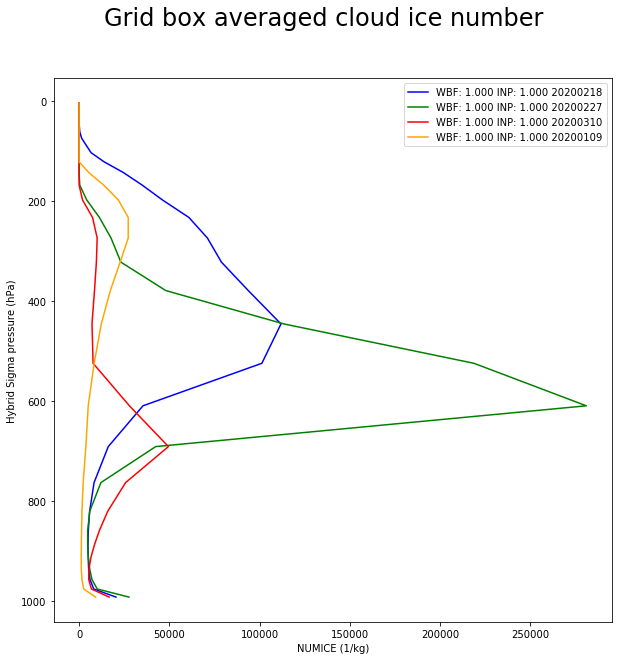

In [46]:
xx = cam61_arctic_comp.plot_single_var('NUMICE')

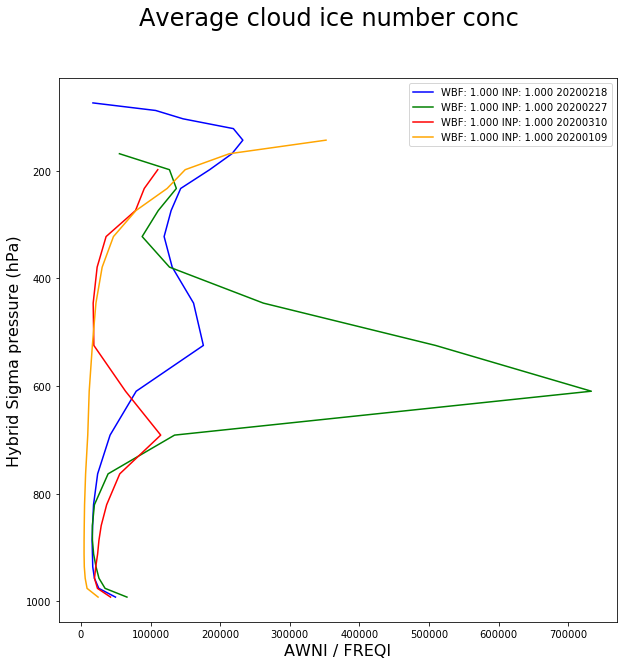

In [47]:
yy = cam61_arctic_comp.plot_var_ratio('AWNI','FREQI')

## Going the low-tech route and not using the metric class. Bad.

In [4]:
arctic_ds = xr.open_dataset('%s%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir,cam61_arctic, cam61_arctic))

In [48]:
arctic2_ds = xr.open_dataset('%s%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir,cam61_arctic2, cam61_arctic2))

In [6]:
cam61_ds = xr.open_dataset('%s%s/atm/hist/%s.cam.h0.2000-01.nc' % (case_dir,cam61, cam61))

In [31]:
cam6_ds = xr.open_dataset('%s%s/atm/hist/%s.cam.h0.2000-01.nc' % (case_dir,cam6, cam6))

In [56]:
cases = [cam61_ds, arctic_ds, arctic2_ds, cam6_ds]
cases = [cam61_ds, arctic2_ds, cam6_ds]
names = ['CAM61', 'CAM61_Arctic', 'CAM61_Arctic2', 'CAM6']
names = ['CAM61', 'CAM61_Arctic2', 'CAM6']

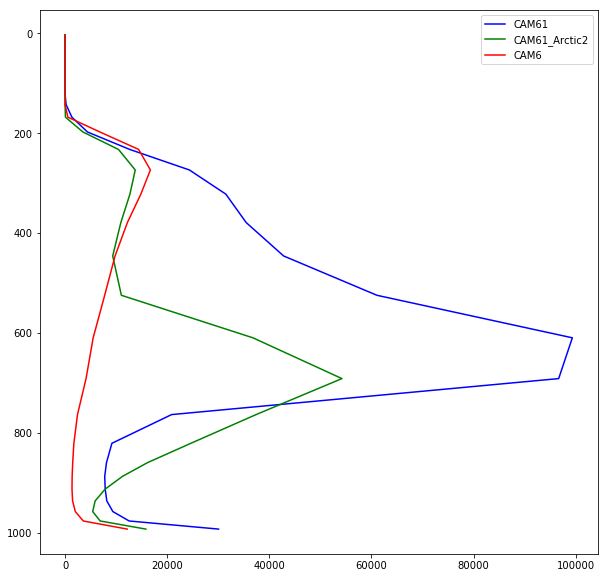

In [65]:
test_plot = plt.figure(figsize=[10,10])
colors = ['blue','green','red','orange','purple','yellow', 'pink']

test_plot.gca().invert_yaxis()
for case, _col, nm in zip(cases, colors, names):
    _da = add_weights(case)
    weight = _da['cell_weight']
    working_da = _da['NUMICE'].sel(lat=slice(67,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
#            weight = working_da['cell_weight']
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
    plt.plot(avg_var, avg_var['lev'], label=nm, color=_col)
    
plt.legend()

This is confusing. In the Arctic, these should be nearly identical. Why is Arctic2 different from CAM61 here?

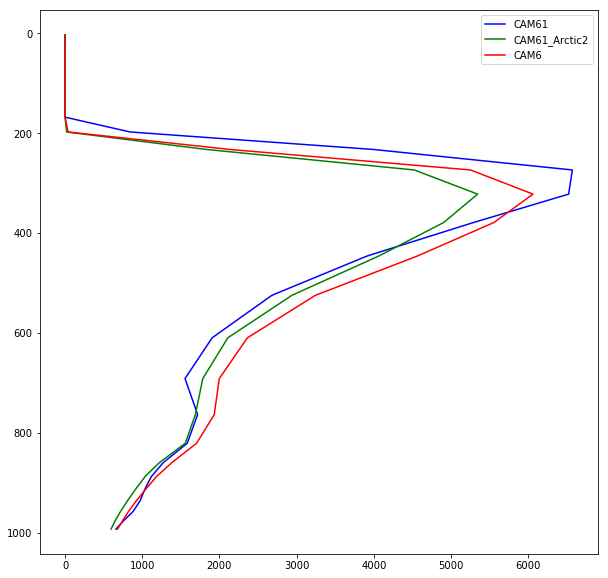

In [67]:
test_plot = plt.figure(figsize=[10,10])
colors = ['blue','green','red','orange','purple','yellow', 'pink']

test_plot.gca().invert_yaxis()
for case, _col, nm in zip(cases, colors, names):
    _da = add_weights(case)
    weight = _da['cell_weight']
    working_da = _da['NUMICE'].sel(lat=slice(-90,-67)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
#            weight = working_da['cell_weight']
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
    plt.plot(avg_var, avg_var['lev'], label=nm, color=_col)
    
plt.legend()

This makes more sense. More INPs outside of the Arctic with CAM61 because the NIMAX cap is made globally.

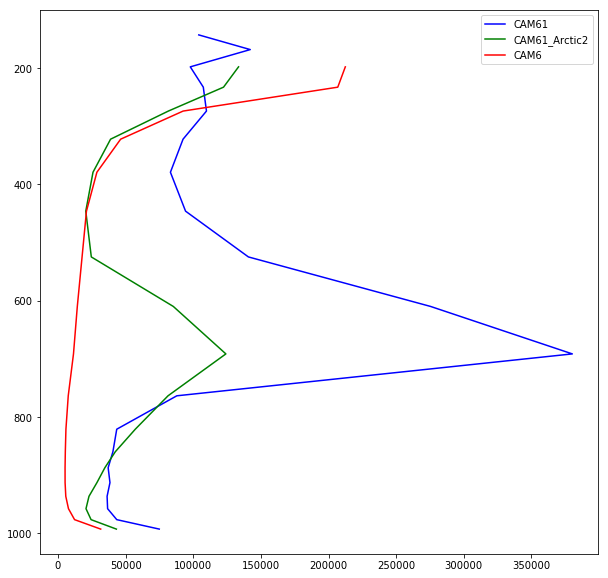

In [66]:
test_plot = plt.figure(figsize=[10,10])
colors = ['blue','green','red','orange','purple','yellow', 'pink']

test_plot.gca().invert_yaxis()
for case, _col, nm in zip(cases, colors, names):
    _da = add_weights(case)
    weight = _da['cell_weight']
    working_da = _da['AWNI']/_da['FREQI'].sel(lat=slice(67,90)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
#            weight = working_da['cell_weight']
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
    plt.plot(avg_var, avg_var['lev'], label=nm, color=_col)
    
plt.legend()

In [ ]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmAAAAJCCAYAAABnD3vtAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzs3XlYVeX6xvHvAlGc5xkVNXPAeR7LNMfKnFJs0DIrT3qs0ymz7HeywTK1EjXNzCkrNSuzU5kzaWlOR1DLWdEccEBTHACB9fvjZRBFRdjstYH7c11c6NprsR+Onrx5h+e1bNtGRERERNzHy+kCRERERHIaBTARERERN1MAExEREXEzBTARERERN1MAExEREXEzBTARERERN1MAExEREXEzBTARERERN1MAExEREXGzXE4XcCslSpSw/f39nS5DRERE5Ja2bNly2rbtkre6z+MDmL+/P5s3b3a6DBEREZFbsizrUFru0xSkiIiIiJspgImIiIi4mQKYiIiIiJt5/BowERGR7OrKlSscOXKEqKgop0uR2+Tr64ufnx8+Pj7pel4BTERExCFHjhyhYMGC+Pv7Y1mW0+VIGtm2TUREBEeOHKFy5crp+hqaghQREXFIVFQUxYsXV/jKYizLonjx4hkauVQAExERcZDCV9aU0T83BTARERERN1MAExERyeHCw8MJDAykatWq1KpVi65du7Jnzx4APvzwQ3x9fTl37lzS/cHBwViWxYwZM5Kubd26FcuyGD9+fNK1SZMmUb16dQICAhg+fDgAERER3HPPPRQoUIChQ4e66Tv0PApgIiIiOZht2/To0YO2bduyf/9+/vzzT9555x1OnDgBwLx582jSpAmLFi1K8VydOnVYsGBB0u/nz59PvXr1kn6/evVqFi9ezLZt2/jjjz948cUXAbN78K233koR1HIiBTAREZEcbPXq1fj4+DB48OCka/Xr16dNmzbs37+fCxcu8PbbbzNv3rwUz1WsWJGoqChOnDiBbdv8/PPPdOnSJen1qVOnMmLECPLkyQNAqVKlAMifPz+tW7fG19fXDd+d51IbChEREQ/w/PMQEuLar1m/PkyYcPN7duzYQaNGjVJ9bd68efTr1482bdqwe/duTp48mRSkAHr37s3ChQtp0KABDRs2TApbAHv27GHt2rWMHDkSX19fxo8fT5MmTVzyfWUHGgETERGRVM2fP5/AwEC8vLzo2bMnCxcuTPF6nz59WLhwYVJQu1psbCxnz57l999/Z9y4cfTp0wfbtt1ZvkfTCJiIiIgHuNVIVWYJCAjg66+/vu76tm3b2Lt3Lx06dAAgJiaGKlWqMGTIkKR7ypQpg4+PD8uXLycoKIh169Ylvebn50fPnj2xLIumTZvi5eXF6dOnKVmyZOZ/U1mARsBERERysHbt2hEdHc306dOTrm3atInnnnuOUaNGERYWRlhYGMeOHePo0aMcOnQoxfNvvvkm7733Ht7e3imud+/enVWrVgFmOjImJoYSJUpk/jeURWgETEREJAezLItFixbx/PPPM2bMGHx9ffH39yc4OJipU6emuLdHjx7Mnz+fZs2aJV1r2bJlql934MCBDBw4kNq1a5M7d27mzJmT1LzU39+f8+fPExMTw3fffceyZcuoVatW5n2THsjy9PnYxo0b25s3b3a6DBEREZfbuXMnNWvWdLoMSafU/vwsy9pi23bjWz2rKUgRERERN1MAExEREXEzBTARERERN1MAExEREXEzBTCRVHj43hQREcniFMBErmHbUK8e9O4NM2bA0aNOVyQiItmN+oCJXOPyZWjaFJYsgW++Mdfq1oUuXcxHy5bg4+NsjSIikrVpBEzkGvnywaefwpEjEBoKY8ZA0aLw/vvQti2UKAG9epl7NDomItlBeHg4gYGBVK1alVq1atG1a1f27NkDwIcffoivry/nzp1Luj84OBjLspgxY0bSta1bt2JZFuPHj0+6NmnSJKpXr05AQADDhw8HICIignvuuYcCBQowdOjQNNWX+LWXLl16299bcHBwiiOSPv74Yz777LMb3h8SEkKLFi0ICAigbt26LFiw4LbfMy00AiZyA5ZlRr7q1oWXX4bz52HFCjMytmQJfPutua9OneTRsVatNDomIlmLbdv06NGDAQMGMH/+fMCEkBMnTnDnnXcyb948mjRpwqJFi3j88ceTnqtTpw4LFizgySefBMzB3fXq1Ut6ffXq1SxevJht27aRJ08eTp48CYCvry9vvfUWO3bsYMeOHWmqcd68ebRu3Zp58+bRqVOnVL8H27bx8rp+XCk4OJgCBQokdewfPHjwTd8rX758fPbZZ1SrVo1jx47RqFEjOnXqRJEiRdJUa1opgImkUaFC0LOn+bBt2LEjOYx98AGMHQsFC8K99yYHMj8/p6sWkazi+Z+fJyQ8xKVfs36Z+kzofPNTvlevXo2Pj0+KYFK/fn0A9u/fz4ULFxg3bhzvvPNOigBWsWJFzp8/z4kTJyhVqhQ///wzXbt2TXp96tSpjBgxgjx58gBQqlQpAPLnz0/r1q3Zt29fmr4H27b5+uuvWb58OW3atCEqKgpfX1/CwsLo0qUL99xzD+vXr+e7775j586dvPrqq8TFxVGiRAlmzJjBxx9/jLe3N59//jmTJk1i5cqVFChQgBdffJF9+/YxePBgTp06hbe3NwsXLuTOO+9Meu9y5cpRqlQpTp065fIApilIkXSwLDPyNXw4rF4NERFmRCwwEDZtgqefhgoVUt4TE+N01SIi19uxYweNGjVK9bV58+bRr18/2rRpw+7du5NGsRL17t2bhQsXsm7dOho2bJgUtsAcwL127VqaNWvG3XffzaZNm9JV32+//UblypWpWrUqbdu25aeffkp6bffu3fTv35+tW7eSL18+nnrqKb755htCQ0NZuHAh/v7+DB48mH/961+EhITQpk2bFF/7kUceYciQIYSGhrJu3TrKli2b4vWNGzcSExND1apV01X7zWgETMQFChWCHj3Mh23DH38kj45NmADjxpnRsfbtk0fHKlRwumoR8SS3Gqlywvz581m0aBFeXl707NmThQsXMmTIkKTX+/TpQ9++fdm1axf9+vVLsdYqNjaWs2fP8vvvv7Np0yb69OnDgQMHkg7kTqt58+YRGBgIQGBgIHPnzqVnz54AVKpUiebNmwPw+++/c9ddd1G5cmUAihUrdtOvGxkZydGjR+nRowdgpkavdvz4cR577DHmzJmT6tRmRimAibiYZUHt2ubjpZcgMhJWrkwOZN99Z+4LCEgOY61bQ+7cztYtIjlTQEAAX3/99XXXt23bxt69e+nQoQMAMTExVKlSJUUAK1OmDD4+PixfvpygoKAUAczPz4+ePXtiWRZNmzbFy8uL06dPU7JkyTTXFhcXxzfffMP333/P6NGjsW2biIgIIiMjATOdmci27dsKd/ZNGj6eP3+e++67j7fffjsp4LmapiBFMlnBgtC9O0ybBocOmbVj48ZB6dIQFGRGxYoXT77n8GGnKxaRnKRdu3ZER0czffr0pGubNm3iueeeY9SoUYSFhREWFsaxY8c4evQohw4dSvH8m2++yXvvvYe3t3eK6927d2fVqlWAmY6MiYmhRIkSt1XbihUrqFevHn/99RdhYWEcOnSIXr168V3iT7JXadGiBb/88gsHDx4E4MyZMwAULFgwKbBdrVChQvj5+SV9rejoaC5dukRMTAw9evSgf//+PPTQQ7dV7+1QABNxI8syI18vvmhGxSIizIjYI4/A1q0weDBUqpTyHq0dE5HMZFkWixYtYvny5VStWpWAgABGjRpFcHBw0vRcoh49eiTtlEzUsmVLunfvft3XHThwIAcOHKB27doEBgYyZ86cpBEqf39/XnjhBWbPno2fnx9//vlnqrXNmzfvuhp69erFl19+ed29JUuW5JNPPqFnz57Uq1ePvn37AvDAAw+waNEi6tevz9q1a1M8M3fuXCZOnEjdunVp2bIl4eHhfPXVV6xZs4bZs2dTv3596tevT0iIazdHAFg3G4LzBI0bN7Y3b97sdBkimc62YefO5KnKNWvgyhXInz/l2rFKlZyuVERcZefOndSsWdPpMiSdUvvzsyxri23bjW/1rNaAiXgIy4JatczHv/8NFy7AqlXJgez77819NWuaINa1q1k7dtWmIxERySIUwEQ8VIEC0K2b+bBt2LUrOYxNnmx6j2l0TESyi2bNmhEdHZ3i2ty5c6lTp45DFWUuBTCRLMCyzMhXzZrwwgtmdGz16utHx2rUSA5jd92l0TERyTo2bNjgdAlupUX4IllQgQLwwAMwZQocOGDWjn3wgekt9tFH0LEjFCuWfI/OrBQR8SwKYCJZnGWZka9//QuWLYMzZ0wIy5sXfvgBhgyBFi2crlJERK6mKUiRbCAmBn77DX76yUxJ/vGHuV65slms/8gjztYnIiIpaQRMJIs6ehQ+/RR69YISJaBdO9PYtWxZMx25axfs328W7GsETERuJjw8nMDAQKpWrUqtWrXo2rUre/bsAeDDDz/E19eXc+fOJd0fHByMZVnMmDEj6drWrVuxLIvx48cnXZs0aRLVq1cnICCA4cOHu+8bygI0AiaSRcTGwvr1yaNcoaHmeoUK8PDDZqSrXTuzPkxEJK1s26ZHjx4MGDAgqclqSEgIJ06c4M4772TevHk0adKERYsW8fjjjyc9V6dOHRYsWMCTTz4JmHMj69Wrl/T66tWrWbx4Mdu2bSNPnjzXHeSd0ymAiXiw8HD4+WcTuJYtg7//hly5TP+vsWNN6KpVy6wDExFJj9WrV+Pj48PgwYOTrtWvXx+A/fv3c+HCBcaNG8c777yTIoBVrFiR8+fPc+LECUqVKsXPP/9M165dk16fOnUqI0aMIE/CduxSpUq55xvKIhTARDxIXBxs3Jg8yrVli7letqyZauzaFe69FwoVcrZOEckEzz8Prj7ypn59mDDhprfs2LGDRo0apfravHnz6NevH23atGH37t2cPHkyRZDq3bs3CxcupEGDBjRs2DApbIE5/3Ht2rWMHDkSX19fxo8fT5MmTVzzfWUDCmAiDjt1CpYuNaFr6VKzi9HLC1q2hHfeMaGrbl2NcomI+82fP59Fixbh5eVFz549WbhwIUOGDEl6vU+fPvTt25ddu3bRr18/1q1bl/RabGwsZ8+e5ffff2fTpk306dOHAwcOJJ0HmdMpgIm4WXy8GdlKHOXauNF0ui9VyvTt6toVOnSAokWdrlRE3OoWI1WZJSAggK+//vq669u2bWPv3r106NABgJiYGKpUqZIigJUpUwYfHx+WL19OUFBQigDm5+dHz549sSyLpk2b4uXlxenTpylZsmTmf1NZgHZBirjBmTMwfz707w9lykDTpvDGG2ZU6403YPNmOH4cZs+GPn0UvkTEfdq1a0d0dDTTp09PurZp0yaee+45Ro0aRVhYGGFhYRw7doyjR49y6NChFM+/+eabvPfee3h7e6e43r17d1atWgWY6ciYmBhKlCiR+d9QFqERMJFMYNtmKUfiKNf69Wbkq3hx6NzZjHJ17GjaR4iIOMmyLBYtWsTzzz/PmDFj8PX1xd/fn+DgYKZOnZri3h49ejB//nyaNWuWdK1ly5apft2BAwcycOBAateuTe7cuZkzZ46mH69i2bbtdA031bhxY3vz5s1OlyFyS+fOwfLlJnT9/LMZ0QJo3NgEri5doEkTuOaHRBHJwXbu3EnNmjWdLkPSKbU/P8uytti23fhWz2oETCSdbBt27Ege5frtN9Orq0gR6NTJhK5OnaB0aacrFRERT6MAJnIbIiNh5crk0HXkiLlevz4MH25CV7NmpleXiIjIjeifCZGbsG1zpE9i4FqzBq5cgYIFzRquN94wa7rKlXO6UhHJqmzb1tqoLCijS7gUwESucfEirF6dHLrCwsz12rXhX/8yo1wtW4KPj6Nlikg24OvrS0REBMWLF1cIy0Js2yYiIgJfX990fw0FMBFg797kwBUcDNHRkD+/6Tr/yitmAX2FCk5XKSLZjZ+fH0eOHOHUqVNOlyK3ydfXFz8/v3Q/n+4AZllWBeAzoAwQD3xi23aQZVnFgAWAPxAG9LFt+2zCM68ATwJxwDDbtpemu3KRDLh8GX75xQSun36CffvM9Ro1YMgQM8rVujVcdaqGR7kYc5H8ufM7XYbcSmysOdbASy0XJXU+Pj5UrlzZ6TLEARn5r0Is8G/btmsCzYEhlmXVAkYAK23brgasTPg9Ca8FAgFAZ2CKZVnakC9u98svph9Xly4wfTpUrw4ffQQHDsDOnfD++9C+veeGrx0nd+Af5M/Sffr5xePNnw9VqsBffzldiYh4mHSPgNm2fRw4nvDrSMuydgLlgQeBtgm3zQGCgZcTrs+3bTsaOGhZ1j6gKbA+vTWIpEehQmaKsX17+O9/IW9epytKu4sxF+mzsA/eljf1y9R3uhy5lTlzzOhX+fJOVyIiHsYl4+KWZfkDDYANQOmEcJYY0hKPTS8PXP1j4JGEa6l9vacty9psWdZmzYuLqzVoAM89Z9pJZLUev8OWDGPX6V183vNzShdQgzGP9tdf5i/ZY49pClJErpPh/ypYllUA+AZ43rbt8ze7NZVrqe7htG37E9u2G9u23ViHdkpmeOst8PeHp56CqCinq0mbL7d/ycyQmbza5lXurXKv0+XIrXz+uelj0r+/05WIiAfKUACzLMsHE76+sG3724TLJyzLKpvwelngZML1I8DV+8j8gGMZeX+R9MqfH6ZNg927YfRop6u5tb0Re3nmh2doXbE1o9qOcrocuRXbNtOPrVtD1apOVyMiHijdAcwyDUtmADtt2/7gqpe+BwYk/HoAsPiq64GWZeWxLKsyUA3YmN73F8mojh3N4MSYMbB9u9PV3Fh0bDSB3wSS2zs3X/b8klxe6h7j8TZuNOl+wIBb3ysiOVJGRsBaAY8B7SzLCkn46AqMATpYlrUX6JDwe2zb/gP4CvgT+BkYYtt2XIaqF8mgDz6AokVh0CCI89C/jcOXD+d/x//HrAdnUaGwmpFlCXPmgK8vPPSQ05WIiIfKyC7IX0l9XRdA+xs8MxrIAhM+klMULw5BQfDwwzB5slmc70kW71rMxI0Tea7Zc3Sr3s3pciQtoqNN+4kePaBwYaerEREPpa05kuMFBprGqyNHJh875AkOnzvME4ufoGHZhrx373tOlyNp9d//wtmzmn4UkZtSAJMcz7Jg6lTz68GDzfppp12Ju0K/b/oRGx/Lgt4LyJPLQ7vCyvXmzDGns9+rnaoicmMKYCJAxYrw7ruwdCl8+aXT1cDrwa+z7q91fPLAJ9xR7A6ny5G0OnHCnG/16KPgrYM+ROTGFMBEEjz7LDRvbtaBOdn/d/n+5Yz5dQyDGgwisHagc4XI7fvyS7ObQ9OPInILCmAiCby94dNP4fx5eOEFZ2oIvxDOo4sepVbJWgR1CXKmCEm/OXOgcWOoVcvpSkTEwymAiVwlIABeecU0Mf/5Z/e+d7wdz2OLHiMyOpIFvReQzyefewuQjAkNNR8a/RKRNFAAE7nGq69CjRpmQf6FC+573zG/jmHFgRVM7DKRgFIB7ntjcY05c8DHB/r1c7oSEckCFMBErpEnj5mKPHwY/u//3POevx3+jf+s/g+BtQN5ssGT7nlTcZ0rV+CLL+D++01zORGRW1AAE0lFq1ZmUX5QEGzYkLnvdebyGfp90w//Iv5Mu38a5pQvyVKWLoWTJzX9KCJppgAmcgPvvAPly8NTT0FMTOa8h23bPLH4CcIvhLOg9wIK5SmUOW8kmWvOHChRArp0cboSEckiFMBEbqBQIdOgdft2GDcuc95j4oaJfL/7e8Z1GEejco0y500kc505A99/b86zyp3b6WpEJItQABO5ifvvh7594c03Ydcu137tLce28NLyl+hWvRvDmg1z7RcX91mwwAyRavpRRG6DApjILQQFQf788PTTrjumaNPRTfT9ui+lC5RmZreZWveVldi26Xi/Zg188on5C1K7NjRo4HRlIpKF5HK6ABFPV7q06Q02fDgcO2bWhaXHlbgrfLvzW4I2BLH+yHoK5SnETw//RPF82jXnkWJiYN8+2L3bDH9e/fnvv5Pvy5cPZs82h4qKiKSRAphIGtStaz4fPHj7Aez0pdN8suUTpmyawtHIo9xR7A6COgfxeP3HtejeabYNp09fH7J27TJ/2HFxyfeWK2caxD38MFSvbn5dvTpUqABemkwQkdujACaSBpUrm88HDkDr1ml7ZvuJ7QRtCOKL7V8QFRtFhyodmHb/NLpU64KXpX+w3erKFfOHd23I2r3bLKJPlCcP3HmnmU4MDEwOWdWrQ8GCztUvItmOAphIGlSqZGaYDhy4+X1x8XH8sOcHgjYEsTpsNXlz5WVAvQEMazaMWiV1PmCmi4hIfcpw/36IjU2+r0wZE64eesh8TgxaFSuaQ0FFRDKZAphIGuTJA35+Nw5g56LOMWPrDCZvnMzBvw9SoVAF3rv3PQY1HESxvMXcW2x2FxtrpgevDVm7dpnpxES5c0O1auaAz169Uo5mFS7sXP0iIiiAiaRZlSrXB7A9EXuYuGEis0Nmc/HKRdpUbMPYDmPpXqM7ubz0f68MOXvWBKtrpwz37TNTiolKlTLhqkeP5JBVowb4+2s0S0Q8lv6FEEmjKlXMiTO2bbNs/zKCNgSxZN8Scnvnpl/tfgxrNoyGZRs6XWbWEhcHYWHXh6xdu8zRPoly5TKjWdWrw4MPplwEX7SoY+WLiKSXAphIGpWvfIFj5eZSc/JEdp/ZRZkCZXij7Rs80+gZShco7XR5nu3cuZSjWYmf9+5Nec5TiRImVD3wQMqQVbky+Pg4V7+IiIspgIncQtjfYUzeOJmpfAr3n8PHbszcHnPpE9CH3N46eiZJXBwcPpz6Ivjjx5Pv8/aGqlVNuOraNeUi+OLqiSYiOYMCmEgqbNtmzaE1BG0IYvHuxVhYtC3dm5Wjh/HulBbcXzcHN92MjIQ9e66fMty7F6Kiku8rWtQEq86dU45mVamiMxNFJMdTABO5SlRsFF9u/5KJGyYSeiKU4nmL83Krl3m2ybP4XPajzGCzAS/bi4+HI0euD1m7d8PRo8n3eXmZQFWjBnTsmHIRfIkS6g4vInIDCmAiwLHIY0zZNIVpW6Zx+tJpapeqzfQHpvNInUfI65MXALugOXXmVr3AspSLF5NHs64OWbt3w+XLyfcVLmxCVfv2KUNW1aqmR4eIiNwWBTDJ0TYc2UDQhiAW/rmQuPg4ulXvxnPNnqOtf9vrDsi2LDPYk+VGwGzbjFql1jfrr7+S77Mss9i9enW4556U04alS2s0S0TEhRTAJMe5EneFr//8mqANQWw4uoFCeQrxz6b/ZGjToVQpWuWmz6bWC8xjXLpk1mFd29Jh924z0pWoYEETqu6+Ozlk1agBd9wBvr7O1S8ikoMogEmOceriKaZtmcbUzVM5FnmMasWqManLJAbUG0DBPGk7569KFVi50gwqOTIgZNtmR2Fqo1mHD5vXwRRXsaIJVm3apBzNKltWo1kiIg5TAJNsLzQ8lKANQXy5/Uui46LpVLUT0x+YTuc7Ot/2odiVK5vBpFOnTAP2TBMVlXI06+rPkZHJ9+XPb0JVq1YwcGByyKpWzSxYExERj6QAJtlSXHwci3cvZuKGifxy6Bfy+eRjYIOB/LPpP6lZsma6v26VhBnKAwdcEMBsG06cSD1kHTyYPJoFUKGCCVcDBqRcBF++vEazRESyIAUwyVbOXj6bdCj2oXOHqFS4EuM6jOPJBk9SNG/Gj6y5OoA1b57Gh6KjYf/+1Fs6nDuXfF/evCZYNWkCjz2WHLLuvNOMdImISLahACbZwq7Tu5i4YSJzQudw6col7qp0Fx90+oBu1bu59FBsf3/z+bqF+LZt5iVTG806cMD01UpUvrwJV488knI0y8/P9NUSEZFsTwFMsqx4O56l+5YStCGIpfuXksc7Dw/XeZhhzYZRv0z9THnPfD5XaFNyP0WCd4HPNWHr7NnkG319zTqsBg2gX7+Uo1kF07bgX0REsi8FMMlyLsRcYHbIbCZtnMSeiD2ULVCWt+55i6cbPU2p/C5aGR8RkfpOw/37WRMXBysxH2XLmnDVt2/KnYYVK5ozD0VERFKhACZZxoGzB5i8cTIzts7gfPR5mpZvyhc9v6B3rd7pOxQ7NtZMD6YWtCIiku/LnduMZtWpA71783FwDX7aX53vd1c3HeJFRERukwKYeDTbtgkOCyZoQxDf7/4eby9vetfqzXPNnqO5XxpXwZ89e8PRLK5cSb6vVCkzgtWzZ8q1Wf7+KUazjr8OP6yHmLygI6VFRCQ9FMDEI8XGxzJ/x3zG/jaW7Se3UyJfCV5t8yr/aPwPyhcqf/OHIyJg2jT4+WcTtk6eTH7Nx8d0fK9RA7p3Tw5a1atD0bTtkqxUyay5DwszS7pERERulwKYeJSYuBjmhs7l3V/fZf/Z/QSUDGBGtxn0q90v6VDsG9q3Dz78EGbNMgdJN20KDzyQcjSrcmXIlf6/9ufPwwcfmKxWsmS6v4yIiORwCmDiEaJio5i1dRZjfhvD4XOHaVi2IYv6LqJb9W4371Zv27BuHYwfD4sXmxGuRx6BF16A2rVdWmNcnNnQuGsXLFuW5gEzERGR6yiAiaMuXbnEJ1s+Ydy6cRyLPEYLvxZ8fN/HdL6jM9bNOrzHxsKiRfD++7BhAxQrBq++CkOHQpkymVLryy/DTz/BlCnQrl2mvIWIiOQQCmDiiMjoSKZsmsL769/n1KVTtPVvy9wec7nH/56bB6/ISJg5EyZMMIuwqlaFyZPh8ccztVv8rFkm6w0dCv/4R6a9jYiI5BAKYOJWZy+fZdLGSUz4fQJno87SqWonXrvrNVpXbH3zB48ehUmT4OOPzfE9rVqZxVjdumV6v621a+GZZ6BDB7PETEREJKMUwMQtTl86zYfrP2Typsmcjz5Pt+rdeK3NazQp3+TmD4aGmqGnefPMcT69esG//w3Nmrml7oMHTVeKypVhwYIMrd8XERFJon9OJFOFXwhn/LrxTN08lctXLtO7Vm9GthlJvTL1bvyQbcPOKPtEAAAgAElEQVTSpWZh/cqVZmrx2Wfh+edNEnKT8+fNJsrYWPjvf7XoXkREXEcBTDLFX+f+YuxvY5n+v+lcib/Cw3Ue5pXWr1CrZK0bPxQdDV98YaYW//gDypWDMWPg6afdnn7i4uDhh82Ox6VL1e9LRERcSwFMXOrA2QOM+XUMs0NmY2PTv25/XmnzCncUu+PGD0VEwNSpZjH9iRNQty589pk5XzG3M73mR4yAH380Ox7bt3ekBBERycYUwMQldp/ezbu/vsvn2z7H28ubQQ0H8XKrl6lUpNKNH7q2cWrnzmZ9V/v2cLOdkJls1iwz+zlkiHY8iohI5lAAkwzZcXIHo9eOZsGOBfjm8uWfTf/JS61eolzBcqk/YNvw229mYX1i49RHHzWNUwMC3Ft8KhJ3PN57r+l0ISIikhkUwCRd/nf8f7y95m0W7VpEgdwFGN5qOC+0eIFS+Uul/kBi49Tx42HjRrc0Tr1dV+94/Oor7XgUEZHMo39i5Lb8fuR33lrzFj/t/YnCeQrzn7v+w7Bmwyier3jqD1zbOPWOO+Cjj2DAgExtnHq7zp83LcW041FERNxBAUzS5JewX3hrzVusPLiS4nmLM7rdaIY0GUJh38KpP3D0KEycCNOmJTdO/fBD09chkxun3q7EHY87d8LPP2vHo4iIZD4FMLkh27ZZfmA5b695m7WH11I6f2nGdxjPM42foUDuAqk/5HDj1PRI3PH40Udm7ZeIiEhmUwCT69i2zQ97fuDttW+z8ehG/Ar5ManLJJ5s8CR5ffKm9oAZOnr//eTGqUOGwHPPubVxanrMnp284/HZZ52uRkREcgoFMEkSb8fz7c5veXvN24SeCMW/iD/T7p/GgHoDyJMrz/UPREUlN079809HG6emx6+/mlK141FERNxNAUyIjY9lwY4FjF47mp2nd3Jn8TuZ/eBsHq7zMD7ePtc/cG3j1Hr1HG+cersOHoQePbTjUUREnKF/dnKwK3FXmLttLu/++i77zuwjoGQA83rN46FaD+HtlcpC+b17zUL62bOTG6e++CK0a+do49TbFRmpHY8iIuIsBbAcKDo2mlkhsxjz6xgOnTtEgzIN+LbPtzxY40G8LK+UN3t449TbpR2PIiLiCRTAcpBLVy4xfct0xq4by7HIYzT3a86U+6bQ5Y4uWNeOYMXGwrffmuCV2Dh15EizWt1DGqemxyuvwA8/aMejiIg4SwEsB4iMjmTq5qm8v/59Tl48yd2V7uaz7p/RrnK764NXZCTMmAFBQR7dODU9Zs+GcePMbkfteBQREScpgGVjf0f9zaQNk5iwYQJnLp+hY9WOvNbmNdpUanP9zUeOwKRJyY1TW7f22Map6ZG447F9e+14FBER5ymAZUOnL51mwu8TmLRxEuejz/PAnQ8wss1Imvml0gw1JMRMM86fn2Uap96usDCz49HfHxYuNMvYREREnKQAlo2EXwjn/XXvM3XzVC5duUSvWr0Y2WYk9cvUT3ljFm6cersiI80gnnY8ioiIJ1EAywaOnD/CuN/G8cn/PiEmLoZ+tfvxaptXqVWyVsobr22cWr48vPeemZsrUsSZ4jPRtTseq1d3uiIRERFDASwLO3j2IO/99h6zQmYRb8fTv25/RrQeQbXi1VLemA0ap6ZH4o7HyZO141FERDyLAlgWFB0bzdCfhjIrZBbeXt4MrD+Ql1u/jH8R/5Q3XrkCL70En3xiGqd26WLWd2Wxxqnp8fnnZsfjP/5hZldFREQ8iQJYFjRl0xQ+3fopQ5sMZUTrEZQvVD71G0eNMu0kHn/cdKzPgo1T0yM+Hl57zewjCApyuhoREZHrKYBlMeejzzN67Wg6VOnApK6TbnzjL7/Au+/CwIGmr1cOsno1HDpkzgXXjkcREfFEXre+RTzJ++veJ+JyBO+0f+fGN505Y44LuuOOHDkENHOm2VPQvbvTlYiIiKROI2BZyMmLJ3l//fs8VOshGpdrnPpNtg1PPWUW269fDwUKuLdIh/39tzlB6cknwdfX6WpERERSpwCWhYxeM5qo2CjeuuetG980Y4ZJIGPHQqNG7ivOQ8yfb7ptPPGE05WIiIjcmKYgs4iwv8OYunkqAxsMpHqJGzS02rXLNFNt397sdsyBZs6EunWhYUOnKxEREbkxBbAs4vXg1/H28ub1u19P/YboaNN1NG9e0+PLK+f90W7fDps2mX0H2bzLhoiIZHGagswCtp/YztzQubzU8qUbt5wYORK2boXvvoNy5dxboIeYNcvsenzkEacrERERubmcN0ySBY1cNZJCeQrxcuuXU79h+XJzruM//gEPPuje4jxETIxpvtqtG5Qo4XQ1IiIiN6cA5uF+O/wb/93zX15u9TLF8ha7/oZTp6B/f6hVC8aPd3+BHuLHH83/FAMHOl2JiIjIrWkK0oPZts2IlSMoU6AMw5oNS+0GkzjOnoWlSyFfPvcX6SFmzjQzrx07Ol2JiIjIrWkEzIMt2beEXw//yn/u+g/5c+e//oYpU8xp02PHmq1/OdTx4/DTT2YgMJd+pBARkSxAAcxDxdvxvLLyFaoWrcqghoOuv2HHDtNqoksX+Oc/3V+gB5k715z/qN5fIiKSVWi8wEPN2z6PbSe28WXPL/HxvuZAw8uXoV8/KFzYbP3LwT0XbNtMP7ZuDXfe6XQ1IiIiaaMA5oFi4mL4v9X/R/0y9elbu+/1NwwfbkbAliyB0qXdX6AHWb8edu+Gl2+wQVRERMQTKYB5oOlbpnPw74MseWQJXtY1s8Q//ACTJ8Pzz0Pnzs4U6EFmzoT8+eGhh5yuREREJO20BszDXIi5wFtr3uLuSnfTqWqnlC8eP24WOtWrB2PGOFOgB7l4ERYsgD59ctyZ4yIiksVpBMzDBP0exImLJ1jUdxHW1Wu74uPh8cdN6vjyS8iTx7EaPcXXX8OFC+r9JSIiWY8CmAeJuBTB2HVjebD6g7So0CLlixMmwLJlMHWqaboqzJwJ1apBq1ZOVyIiInJ7NAXpQcb8OobI6EhGtxud8oWtW2HECHPM0DPPOFOch9m3D9asMTOyOXgTqIiIZFEKYB7ir3N/MWnjJPrX609AqYDkFy5eNC0nSpaETz9V2kgwezZ4eZnmqyIiIlmNpiA9xBu/vIGNzRtt30j5wr/+BXv2mAO3dco0AHFxJoB17gzlyztdjYiIyO3TCJgH2HV6F7NCZvFs42epVKRS8gvffAPTp5u+X+3bO1egh1m+HI4eVed7ERHJuhTAPMBrq14jn08+Xm3zavLFI0fgqaegcWN4803nivNAM2dC8eLwwANOVyIiIpI+CmAO23R0E9/s/IYXW7xIyfwlzcW4OHjsMYiJMS0ncud2tkgPEhEBixfDo4+qE4eIiGRdWgPmsFdWvkKJfCV4ocULyRfHjoXg4OQ+C5Lkyy9NLtX0o4iIZGUKYA5acWAFKw+uZEKnCRTMU9Bc3LAB/u//THv3xx93tD5PNHMmNGxoDgMQERHJqjQF6ZB4O54RK0ZQqXAlBjcebC5GRsLDD5utfR9/rJYT19i6FUJC1PleRESyPo2AOeSbP79hy/EtzOk+hzy5EhYzDR0KYWFm+rFoUSfL80izZpl1X/36OV2JiIhIxmgEzAFX4q4wctVIAkoG8EidR8zFefPgs8/gtdegTRtnC/RAUVHw+efQvTsUK+Z0NSIiIhmjETAHzA6Zzd4ze1kcuBhvL28z6jV4MLRoYdZ/yXW+/x7OntX0o4iIZA8aAXOzy1cuM+qXUbTwa8EDdz4AsbHwSMIo2BdfQC5l4tTMnAkVKqgfrYiIZA/6197NJm+czLHIY8zrNQ/LsmD0aFi3zoSvypWdLs8jHTkCy5bByJHg7e10NSIiIhmnETA3+3z759xV6S7uqnSXGf364APo2dPsfpRUHTwItg01azpdiYiIiGsogLlRdGw0f576k1YVWpkLGzfC+fMQGOhsYR6uZUvTmWPuXKcrERERcQ0FMDfaeXonsfGx1Cud0EV0+XLT66tdO2cL83De3qbz/dKl8NdfTlcjIiKScQpgbhQSHgJA/TL1zYUVK6BRI3OytNzUwIFmGnLWLKcrERERyTgFMDcKDQ8lb6683FHsDtP1/vffoUMHp8vKEipXNjsgZ86E+HinqxEREckYBTA3CjkRQt3SdU3vr+Bgswj/3nudLivLGDQIDh2ClSudrkRERCRjFMDcxLZtQsNDk9d/rVgBefNCq1bOFpaFJHbB//RTpysRERHJGAUwN/nr/F+cjTqbvP5r+XK46y5zuKGkia8vPPoofPcdnD7tdDUiIiLppwDmJqHhoQDUK1PPdBbduVPTj+nw5JMQE2POhRQREcmqMhzALMvytixrq2VZPyT8vphlWcsty9qb8LnoVfe+YlnWPsuydluW1Smj752VhISHYGFRp1Sd5EVMWoB/2+rWhSZNYMYMsytSREQkK3LFCNhzwM6rfj8CWGnbdjVgZcLvsSyrFhAIBACdgSmWZeWYg2VCT4RStVhVCuYpaKYfS5WCOnWcLitLGjQIduwwfWxFRESyogwFMMuy/ID7gKuXRT8IzEn49Ryg+1XX59u2HW3b9kFgH9A0I++flYSEh5j1X7ZtFuC3bw9emgFOj8BAyJfPjIKJiIhkRRlNABOA4cDVnZlK27Z9HCDhc6mE6+WBq/uYH0m4dh3Lsp62LGuzZVmbT506lcESnRcZHcn+s/vNDsgdO+DECU0/ZkChQtCnD8ybBxcuOF2NiIjI7Ut3ALMs637gpG3bW9L6SCrXUl3FY9v2J7ZtN7Ztu3HJkiXTW6LH2HZiG5DQAX/5cnNRC/AzZNAgE76++srpSkRERG5fRkbAWgHdLMsKA+YD7SzL+hw4YVlWWYCEzycT7j8CVLjqeT/gWAbeP8sIPZGwA7J0PRPAqleHChVu8ZTcTMuWUKOGpiFFRCRrSncAs237Fdu2/Wzb9scsrl9l2/ajwPfAgITbBgCLE379PRBoWVYey7IqA9WAHLGMOiQ8hGJ5i+GXpySsWaPpRxewLNOSYt0609FDREQkK8mMVeBjgA6WZe0FOiT8Htu2/wC+Av4EfgaG2LYdlwnv73FCT5gO+Nbvv8OlSwpgLtK/P+TKpVEwERHJelwSwGzbDrZt+/6EX0fYtt3etu1qCZ/PXHXfaNu2q9q2Xd227SWueG9PFxcfx/YT25PXf3l7w913O11WtlCqFHTrBnPmmOasIiIiWYX6IGSyvWf2cjn2sln/tWIFNGsGhQs7XVa2MWiQOZbo+++drkRERCTtFMAyWUh4CACNfKvA5s2afnSxjh3Bz0/TkCIikrUogGWy0PBQfLx8qL79GMTHq/2Ei3l7wxNPwNKlcPiw09WIiIikjQJYJgs9EUrNkjXxWbkaChY0U5DiUgMHms+zZztahoiISJopgGWypCOIVqyAtm3Bx8fpkrIdf39zstOMGRCXI/bViohIVqcAlolOXjzJ8QvHaRPnB/v3a/oxEw0aZKYgV650uhIREZFbUwDLRKHhpgN+692XzQUtwM803btDsWJajC8iIlmDAlgmSjyCqPKWA1C+vDk7RzJFnjzw2GOwaJFpSyEiIuLJFMAyUUh4CBULlCdP8Foz+mWldh65uMqTT8KVK/D5505XIiIicnMKYJko9EQoPS77w5kzWv/lBnXqmE2mn34Ktu10NSIiIjemAJZJomKj2HlqJ10P5TYXFMDc4skn4Y8/YMMGpysRERG5MQWwTPLnqT+Js+Oot/0U1K0LpUs7XVKOEBgI+fNrMb6IiHg2BbBMEhIeQt4YKLl1t0a/3KhgQejTB+bPhwsXnK5GREQkdQpgmSQ0PJR7j+XBK+aK2k+42aBBJnx99ZXTlYiIiKROASyThJwIoe/xYpA7N7Rp43Q5OUqLFlCzplmMLyIi4okUwDKBbduEhody154YaNnSLEoSt7Essxh//Xr480+nqxEREbmeAlgmOHTuELkjzlHhYISmHx3y2GPm2E0txhcREU+kAJYJQsNDaX8w4TcKYI4oVQq6dYPPPoOYGKerERERSUkBLBOEhIfQcT/YRYtCw4ZOl5NjDRpkjiX6/nunKxEREUlJASwThIaH0OlQLqx27cDb2+lycqwOHaBCBS3GFxERz6MAlgnObdtEubOxmn50mLc3PPEELFtmuuOLiIh4CgWwTFAx7Iz5RYsWzhYiPPUUFC0KzZvDF184XY2IiIihAJYJalwpYn5RvryzhQh+frB1K9SvD48+CgMGQGSk01WJiEhOpwCWCapG5+OKtwXFijldigAVK8Lq1fD66/D559CoEWzZ4nRVIiKSkymAZQK/Sz6EF8B0BBWPkCsXjBplgtjly2Z2+MMPIT7e6cpERCQnUgDLBKUj4zme3+Zc1DmnS5Fr3HUXhITAfffBCy/A/ffDyZNOVyUiIjmNAlgmKPp3FMcLmo744nmKF4dvv4WPPoJVq6BePVixwumqREQkJ1EAywT5IyIJLwCHzx12uhS5AcuCZ5+FTZvMUr2OHWHECLhyxenKREQkJ1AAc7UrV8h15m+OF4BDf2sEzNPVqWNC2FNPwXvvQevWcOCA01WJiEh2pwDmaidPYtk2pwt5awoyi8iXD6ZNg4ULYc8eaNAA5s93uioREcnOFMBcLTwcgNjSJRXAspjevc0C/dq1oV8/GDgQLl50uioREcmOFMBc7fhxAHKV89MUZBZUqRL88gu89hrMnm16hoWEOF2ViIhkNwpgrpYwApa3QhWNgGVRuXLBW2+ZHZKRkdCsGUycCLbtdGUiIpJdKIC5WsIIWJFK1Qm/EE5UbJTDBUl6tW0LoaHQqRM89xw88ACcOuV0VSIikh0ogLlaeDgUK4ZfyaoA/HXuL4cLkowoUQIWLzYjYMuXm55hq1Y5XZWIiGR1CmCudvw4lClDpSKVADVjzQ4sC/75T9i4EQoXhnvvhZEj1TNMRETSTwHM1cLDoWxZKhVOCGBaiJ9t1KsHmzeb3ZHvvAN33w1hYU5XJSIiWZECmKsljID5FfLDy/LSCFg2kz8/fPqp6RP2xx9Qv77pHyYiInI7FMBcybaTRsB8vH0oV7CcAlg21bevaU9Rsyb06WM66V+65HRVIiKSVSiAudK5cxAVBWXKAFCpcCVNQWZjlSvDmjXw6qswYwY0bgzbtjldlYiIZAUKYK6U0AOMsmUBqFSkkkbAsjkfHxg92uyQ/PtvaNoUPvpIPcNEROTmFMBcKaEH2NUjYEfOHyEuPs7BosQd2rc3PcPat4ehQ6FHD4iIcLoqERHxVApgrnTtCFjhSsTGx3Is8piDRYm7lCwJP/wAEybAkiVm1+QvvzhdlYiIeCIFMFe6dgRMvcByHMsyXfPXrzc7Jtu1g9dfh9hYpysTERFPogDmSuHhkCcPFCkCoF5gOVjDhrBlC/TvD2++aY41OnzY6apERMRTKIC5UkIPMCwLgIqFKwIaAcupChSAWbPgiy/M7sh69eCbb5yuSkREPIECmCsl9ABLlD93fkrkK8Hhcxr6yMkefhi2boVq1aB3bxg8GC5fdroqERFxkgKYKyWOgF2lUmG1ohCoWhV+/RWGD4dp06BJE9ixw+mqRETEKQpgrnTNCBgk9ALTGjABcueG996DpUvh9GkTwj7+WD3DRERyIgUwV4mJMY2frhkBq1ioIofOHcLWv7KSoGNH0zPs7rvhH/8w05JnzjhdlYiIuJMCmKucOGE+pzICdunKJSIuqyunJCtdGn76CcaPh//+1xzqvXat01WJiIi7KIC5SmIT1lTWgIFaUcj1vLzg3/+GdetM95K2bU3LijgdnCAiku0pgLlKYhPWVEbAQK0o5MYaN4b//Q8eecQ0bW3XDv76y+mqREQkMymAuYpGwCQDChaEzz4zH//7n5mS/O47p6sSEZHMogDmKokjYKVLp7hcLG8x8vvk1wiYpMljj5kAVrmyOdB7yBD1DBMRyY4UwFwlPBxKlAAfnxSXLcsyrSgUwCSNqlUz68L+/W+YMgWaNYM//3S6KhERcSUFMFc5fvy69V+JKhVWLzC5Pblzmx2SS5aYDbaNG8Mnn6hnmIhIdqEA5irh4det/0qkbviSXp07m55hrVvDM89Anz5w9qzTVYmISEYpgLnKzUbAilTizOUzXIi54OaiJDsoUwZ+/hnGjjUL8+vXN1OUIiKSdSmAuYJt33IEDLQTUtLPywteegl++w1y5YK77oLRo9UzTEQkq1IAc4WzZ81RRDcZAQP1ApOMa9oUtm41U5GvvQb33gtHjzpdlYiI3C4FMFe4QQ+wRBoBE1cqVAi++AJmz4ZNm6BePXOckYiIZB0KYK5wgy74icoWLIuPl49GwMRlLAsGDIAtW6BiRejWDYYNg6gopysTEZG0UABzhVuMgHlZXlQoXEEBTFyuenVYvx6efx4mTYLmzWHXLqerEhGRW1EAc4VbjICBeoFJ5smTBz78EH74wawHa9QIZsxQzzAREU+mAOYK4eGQN6850O8G1A1fMtt995meYc2bw6BB0K8fnDvndFUiIpIaBTBXSOwBZlk3vKVS4UocjzzOur/UwEkyT7lysGwZvPsufP011K4NL75orulMSRERz6EA5go36QGWKLB2IH6F/Gg1sxUDFw/k5MWTbipOchpvbxgxAn791awRmzQJOnWCokWhQwfT0DUkBOLjna5URCTnUgBzhZt0wU9Uo0QNdg7ZycutXmbutrlUn1ydqZumEhevTpqSOZo3hxUrTJu6JUtgyBDzs8LLL0ODBuav7COPwJw5cOyY09WKiOQslu3hK3UbN25sb9682ekybq5oUXj0UTPUkAY7T+1k6JKhrDq4ikZlGzHlvik0Ld80k4sUMY4dM8Fs2TJYvhxOJgzGBgSYEbKOHU2n/fz5na1TRCQrsixri23bjW91n0bAMioqCv7++5ZTkFerWbImKx5bwfxe8zl+4TjNP23O0/99mohLEZlYqIhRrhz07w+ff24Gb0NCYNw4c/3jj6FrVyhWDNq1gzFjTK8xTVeKiLiWRsAyKiwMKlc2+/4HDrztxyOjI3njlzeY8PsEivgWYcy9YxjYYCBelrKxuN/ly2btWOLoWGiouV6iBLRvb0bHOnSAChWcrVNExFOldQRMASyjfv8dWrSAH380QwfptOPkDob8NIQ1h9bQrHwzptw3hYZlG7qwUJHbd+JEyunKxJZ3NWokh7G2baFAAUfLFBHxGJqCdJc0NGFNi9qlahM8IJi5PeYS9ncYjT9pzJAfh3D28lkXFCmSPqVLJy/UP3oUtm+H998Hf3+YPh0eeMBMV959N4weDRs3Qpz2lYiI3JJGwDJqyhSzvez48dtaB3Yzf0f9zeurX2fypskUz1ucsR3G0r9ef01LikeJioJ165JHx/73P3O9aNGU05X+/o6WKSLiVpqCdJf//Mf86B8TYxowuVBIeAjP/vgs64+sp1WFVky5bwp1S9d16XuIuMqpU2a6cvlyE8qOHjXXq1VLDmP33AOFCjlbp4hIZlIAc5ennjKH8CVORbpYvB3PnJA5DF8xnLOXzzK06VDeaPsGhX0LZ8r7ibiCbZtDwRNHx1avhkuXzM8ozZubQNaxIzRuDLlyOV2tiIjrKIC5y/33mx/1t27N1Lc5c/kMr616jY83f0zpAqUZ32E8D9d5GOsmxx+JeIroaFi/Pnl0bMsWE9IKFzbTlYn9x6pUcbpSEZGMUQBzl8aNoVQp+Oknt7zd5mObefbHZ9l0bBN3V7qbj7p+RECpALe8t4irRETAypXJgezwYXO9SpXk0bF77oEiRZytU0TkdimAuUv58tC5s+kD5ibxdjyf/u9TXln5Cuejz/N8s+f5z93/oWCegm6rQcRVbBv27EkOY6tXw4UL4OUFzZolj441bQo+Pk5XKyJycwpg7hAfD7lzm8P1Ro92+9ufvnSaV1a8wqdbP6V8wfJ80OkDHqr1kKYlJUu7csW010sMZJs2mf+rFSxouvMnLui/4w7QX3UR8TTqA+YOp0+bpkcZ7AGWXiXylWB6t+msf3I9pfKXou/Xfen4eUd2n97tSD0iruDjA23awJtvmiB2+jR8/TX062c68w8ZAnfeaaYrn37avHbmjNNVi4jcHgWwjEjc+eii/l/p1dyvOZue2sTkLpPZdHQTdabW4dWVr3Ix5qKjdYm4QtGi0KsXTJsGBw7A3r2m/V79+rBgATz0EJQsaaYr/+//YM0a0xVGRMSTaQoyI5YuNeu/fv0VWrVyuhoATl48yfDlw5kTOoeKhSsyodMEutformlJyZZiY033/cR2Fxs2mEHpAgXMEUmJ05XVq2u6UkTcQ1OQ7uCiY4hcqVT+UszuPpu1T6yliG8Ren7Vk/u+vI99Z/Y5XZqIy+XKBS1bwqhR8NtvZnflokXw2GOwcycMGwY1a0KlSvDkk2bE7PRpp6sWEVEAy5jwcPPZ4SnI1LSu2JotT29hQqcJ/Hr4V2pPqc3rq1/n8pXLTpcmkmkKF4bu3c0U5b59sH8/fPyx2UH57bcQGGi6xjRuDK++anZcRkc7XbWI5ESagsyI556D2bPh3DmnK7mp45HHeXH5i3y5/UsqF6nMxC4Tuf/O+50uS8St4uJg8+bk6cr1680UZr585jDxxOnKWrU0XSki6ac2FO7Qpw9s22bOXMkCgsOCGfLTEP489ScP3PkAQZ2DqFy0stNliTgiMhKCg00gW7bM9CIDKFcuOYzde68ZMRMRSSsFMHe46y7TLTI42OlK0uxK3BWCNgQxKngUcXYcr7Z+lZdavYRvLl+nSxNx1KFDZmRs+XJzqHhia4v69ZMDWevW4Kv/q4jITSiAuUO1amYxybx5Tldy246cP8K/l/2br/74ijuK3cHkLpPpdEcnp8sS8QhxceZ418TRsXXrTINYX18zXZnYnb92bU1XikhK2gXpDuHhHrkAPy38CvmxoPcClj26DC/Li85fdKbXV704fO6w0zgyzswAACAASURBVKWJOM7bO3mhfnCwGQ374Qd45hlzbuWLL0Lduma6sn9/mDs3eU+OiEhaKICl14UL5sODWlCkR4eqHdg2eBvvtHuHJXuXUPOjmoz5dQwxcepkKZKoQAG47z6YMAH+/BP++gtmzjS9xpYsMSGsbFmoV8+Es2XL4LI2HIvITWgKMr327jXnoXz2mWk6lA0c+vsQ/1r6LxbtWkT14tX5qOtHtK/S3umyRDxafDyEhCSfXfnrr6YTf5485kilxOnKunXNklERyd40BZnZPLgHWHpVKlKJb/t+y08P/0RsfCz3zr2XwK8DOXr+qNOliXgsLy9o2BBefhlWroSzZ82o2LPPmv9MvPwyNGhgRsgeeQTmzIFjx5yuWkScphGw9PrqK+jbF7ZvNytxs5mo2CjG/jaWd399l1xeuRh19yiGNRuGj7eP06WJZCnHjpldlYn9x06eNNcDApJHx+66C/Lnd7ZOEXEN7YLMbBMnmkasp05BiRJOV5NpDpw9wLAlw/hx748ElAzgo64fcbf/3U6XJZIlxcebn9kSw9iaNaYTf+7c5jjZxHYXDRpoulIkq9IUZGY7fhx8fKB4cacryVRVilbhh4d/YHHgYi7EXKDtnLY8tugxwi9oy5fI7fLyMgv1X3rJhLCzZ83nYcPMTstXXjG7L0uXNscmzZxpFvyLSPajEbD0evxxWLXK7EnPIS5ducS7a99l7Lqx+Oby5a173uLZJs+SyyuX06WJZAvh4Wa6MnFBf+JS0xo1kqcr27Y1uzJFxDNpCjKzde5sfmTduNHpStxub8Re/rnknyzdv5R6pesx5b4ptKzQ0umyRLIV24Y//kiervzlF9PawscHWrRInq5s1Mj0LRMRz6AAltnq1QN/f1i82OlKHGHbNt/u/Jbnlz7PkfNHeKL+E4y5dwyl8uvgPJHMEBUFv/2WPDq2dau5XrQotG+fHMj8/R0tUyTHUwDLbKVLQ/fuMG2a05U46mLMRd5a8xbvr3+fArkL8E67d3i60dN4e+lHcpHMdPKkaXuRGMiOJnSLqVYtOYzdcw8UKuRsnSI5jQJYZoqNNduW/vMfGDXK6Wo8ws5TOxm6ZCirDq6iUdlGTLlvCk3LN3W6LJEcwbZh587kMBYcDJcumanJ5s1NIOvY0Szwz6UlmyKZSrsgM9OJE+a/eFn8GCJXqlmyJiseW8H8XvM5fuE4zT9tztP/fZqISxFOlyaS7VkW1KplOuP8+KNZnrp6tWkCGx1tfk5s0cJ0zOnVCz7+GA4ccLpqkZxNI2DpsWWL+VHyu+/gwQedrsbjREZH8sYvbzDh9wkU8S3CmHvHMLDBQLws5X0RJ0REmOnKZcvMR2JriypVkkfH/r+9+46OqlrfOP7dSYBA6B1CE0FUEGkC0kRQerMgvekVfvaChWJv1+4VG6JSFAQBQZDey6WDgoCKoIL0hN4hJOf3x57cBNLDZE5m5vmslTXhMGfyzlljfNh7n3ffeisULOhunSKBQFOQWWnGDGjfHtasgbqaZkvJlqgtPDTrIZbtWka9yHp82vZTapWq5XZZIkHNceCPPxKmKxcvhlOnbI+yevUS2l3UrWvvuBSRjNEUZFYKwH0gs0K14tVY0mcJ39zxDTuP7aTOiDo8NPMhjp496nZpIkHLGKhSBR5+GKZPt9OVy5bBkCG2U/9rr0GjRrbHdKdO8OmnsH27DW4i4j0aAcuMV1+1C/Dj9xCRNB07d4wXF7/Ix+s+pkjuIrx9+9v0vrG3piVFspmjR22P6fjpyp077fEKFRJGx5o1g8KF3axSJPvyyQiYMaagMWayMeZ3Y8xvxpibjTGFjTHzjTHbPY+FEj1/sDFmhzFmmzGm5ZX8bFft32//eajwlW4FwwvyYesP2dB/A5UKV6LftH40GdWEXw7+4nZpIpJIoUJ2of7nn9uF+tu321GwGjXgu++gc2coVsxOVz7/vB09u3DB7apF/M8VjYAZY8YAyx3H+dIYkxPIAwwBjjiO86YxZhBQyHGcZ40x1wPjgbpAaWABcI3jOLGp/YxsOQJ25512EcWWLW5X4pfinDjGbBzDMwue4ejZozxc92FebvoyBcILuF2aiKTi4kW7+Ud8d/41ayA21m6N1LRpQv+xKlXsVKdIMMryRfjGmPzAJqCik+hFjDHbgKaO4+w3xpQCljiOU8UYMxjAcZx/e543F3jJcZxVqf2cbBnAbr7Z/saZP9/tSvzakbNHeG7RcwxfP5wSeUvw7u3v0v2G7hj95hbxC8eP20X88dOVf/5pj5ctmzBd2by5bX8hEix8MQVZEYgGRhljfjbGfGmMiQBKOI6zH8DzGL83TSSwO9H5ezzH/M+BA+oB5gWFcxfm07afsvb+tZTNX5aeU3ty65hb2Rq11e3SRCQdChRIWKi/Y4cNYMOH2zsop0yBrl2heHHbtWfIEBvWzp93u2qR7OFKAlgYUAv4zHGcmsBpYFAqz09uWCPZ4TdjTH9jzHpjzPro6OgrKDELOI5dA6Y7IL2mTuk6rP7Xaj5v9zmbozZT4/MaPD3vaU6eP+l2aSKSARUrwoABMHkyREfD6tXw8suQOze8807C4v02beA//7GbjWfz+8BEssyVBLA9wB7HcdZ4/jwZG8gOeqYe8TxGJXp+2UTnlwH2JffCjuOMcBynjuM4dYoVK3YFJWaBY8fsP+E0AuZVISaE/rX7s+3hbfS9sS/vrnqX6z65jolbJ5Ld79QVkaTCwhIW6i9fbpvBTpsG995rR8qeeAKqVYMyZaBfP/j2W7u/pUiwyHQAcxznALDbGFPFc6g58CswHejjOdYHmOb5fjrQ1RiTyxhzFVAZWJvZn+8a9QDLUkXzFOWLDl+w6r5VFI8oTpfJXWgxtgXbDm1zuzQRuQL580OHDvDRR7Btm21v8cUX0LCh7UfWoweUKAE1a9otlBYsgHPn3K5aJOtc6V2QNYAvgZzAX0A/bKibCJQD/gE6O45zxPP8ocC9wEXgccdxZqf1M7LdIvxFi+yq0sWL7W0/kmVi42IZvn44QxcN5UzMGZ5q8BRDGw8lImeE26WJiBfFxsJPPyV051+5EmJiIDwcbrklYUF/tWq6u1KyP21FlFW+/db+U+333+291pLlok5H8cz8ZxizaQzlCpRjWKthdLxWe3CKBKpTp2Dp0oR2F7/9Zo+XLJkQxtq2tT3LRLIbbUWUVeKnIEuUcLeOIFI8ojijO41meb/lFAwvSKfvOvHK0le0NkwkQOXNawPWhx/Cr7/azcNHjrSTDrNnQ69e9ldwmzYwerTt3i/ibxTAMio62u5QW0BNQ32tUblGrL9/Pb1v7M2LS17koVkPERuXah9fEQkA8Qv1x4+HgwdtA9jHH7fhrF8/G8batYMxY+x9UiL+IMztAvxOdLTtKqiFCK7IEZqD0R1HUzKiJG+vfJuDpw8y7s5xhIeFu12aiPhASIjtM1a3Lrz1FqxbB5MmwcSJMHOm/fdxy5Zwzz120b/+rSzZlUbAMurQIbsRmrjGGMNbt7/FBy0/YMpvU2g1thXHzumfvSLBxhgbxN55x95VuXo1PPIIbNoEvXvbJrAdOsDYsXDihNvVilxKASyjoqMVwLKJx+s/zrd3fsvK3StpMqoJ+04m21ZORIKAMbbv2Hvv2TC2ahU89BD8/LNdM1asGHTsCOPGKYxJ9qAAllHxU5CSLXS7oRszu8/k72N/0+CrBuoXJiKEhED9+vD++7Brl21r8eCDsGED9OxpR8Y6dbI3tZ/UhhviEgWwjNIUZLZz+9W3s6TPEs7EnKHhyIas2bMm7ZNEJCiEhMDNN8MHH8A//8CKFfB//2fXjvXoYX+d33GHXeCvMCa+pACWETEx9n5nBbBsp3bp2qy8byUFwgvQ7OtmzN6eZo9fEQkyISHQoIHdh3L3brtF0oAB9q7K7t3tyNhdd8GECbYXmUhWUgDLiMOH7aOmILOlSoUrseLeFVQpUoX249szZuMYt0sSkWwqJAQaNbK9xvbsgWXL4P777dqxbt3sv7PvvtveXXn6tNvVSiBSAMuIQ4fso0bAsq2SeUuypO8SmlZoSt9pfXl7xdtq2CoiqQoJgcaNYdgwOzK2dCn86192urJLF/srv3Nn2+5CYUy8RQEsI6Kj7aNGwLK1/LnyM7P7TLpU7cKzC57lyblPEufEuV2WiPiB0FBo0sRuGr5nDyxZYpu9Ll9ue4sVL24fJ0+GM2fcrlb8mQJYRmgEzG/kCsvFt3d9y6N1H+U/a/5Dzyk9uRB7we2yRMSPhIbazcA/+QT27oXFi6FPHztC1rmz/V9Bly7w/fcKY5JxCmAZET8CpgDmF0JMCP9p9R/+3fzfjN8ynrbftuXked3mJCIZFxpq96L89FPYtw8WLbLNXhcvtmvFiheHrl1hyhQ4e9btasUfKIBlRHwAK1zY3Tok3YwxDGo0iFEdR7H478U0HdOUg6cOul2WiPix0FC49Vb47DMbxhYutP3FFi60d1EWK2bvqpw6VWFMUqYAlhGHDkGhQnazMfErfWv0ZVrXafwW/RsNRzbkzyN/ul2SiASAsDBo1gyGD4f9+2H+fNtfbN48uPNOOzLWowf88AOcO+d2tZKdKIBlhLrg+7W217RlUZ9FHD13lAYjG/DT/p/cLklEAkhYGNx2G3z+ORw4YENYt24wd65t9lq8uB0pmz5dYUwUwDJG+0D6vfpl6rPi3hWEh4Vzy+hbWPDXArdLEpEAFBYGt98OI0bYkbG5c+2C/dmz7Z6UxYvbPSp//BHOn3e7WnGDAlhGaBuigHBt0WtZee9KKhSsQJtxbZiwZYLbJYlIAMuRA1q0gC++sCNjc+bYuyhnzoQOHWwY690bZsxQGAsmCmAZoSnIgBGZP5Ll/ZZTv0x9un3fjQ9Xf+h2SSISBHLkgJYt4auv4OBBOyJ21112JKx9eyhRwra6mDkTLqhzTkBTAEsvx9EIWIApGF6QuT3ncse1d/D43McZvGCwuuaLiM/kyAGtWsHIkTaMzZpl14pNmwbt2tkw1q+fPa4wFngUwNLrxAm7GbcCWEDJnSM3kzpPYkDtAby54k36TetHTGyM22WJSJDJmRNat4ZRoyAqyo6AdexoW1m0bWvD2L332hEzhbHAEOZ2AX5D2xAFrNCQUD5r+xml8pbipaUvEX0mmol3TyQiZ4TbpYlIEMqZE9q0sV/nz9vWFpMm2Y77o0bZbkh33GHXkTVvrs5I/kojYOmlbYgCmjGGF5u+yPC2w5mzYw7Nv27OoTOH3C5LRIJcrlx2OnLMGDsyNn26/fPkyXbErGRJu3H4vHl2kkb8hwJYemkELCgMqDOAyZ0ns/HARhqNbMSuY7vcLklEBLBhrH17+Ppru2Zs2jQ7SjZxol3YX7Ik3H+/HTG7eNHtaiUtCmDppX0gg8Yd193BvF7zOHDqAA1GNmDzwc1ulyQiconwcNvC4ptv7MjYDz/YBf0TJtiWFyVLQv/+sGCBwlh2pQCWXpqCDCpNyjdheb/lADQe1Zhlu5a5XJGISPLCw+2C/XHjbBibOtWGsG+/tc1gS5WCAQPsXpUKY9mHAlh6RUfbT3mePG5XIj5yQ4kbWHnvSkrlK0WLb1ow9bepbpckIpKq3LmhUycbvqKjYcoUuz3SuHH2sXRpeOABWLQIYmPdrja4KYClV3wPMGPcrkR8qHzB8vy333+pWaomd0+6m+Hrh7tdkohIuuTObe+WHD/ejox9/73dOPzrr+3dk6VLw4MPwuLFCmNuUABLL+0DGbSK5CnCgl4LaF2pNQ/MfICXlrykhq0i4lfy5IE777RrxKKjbVuLpk3t3ZXNmkFkJDz0ECxdqjDmKwpg6aVtiIJaRM4IpnaZSt8afXl56cv834z/IzZOv6VExP/kyQN33w3ffWdHxiZOhCZNbI+xpk2hTBl4+GFYtkxhLCspgKWXtiEKejlCczCyw0gGNxrMiJ9GcPekuzkbc9btskREMi0iwjZ0nTjRjjN89x00bGi3R7rlFihbFh55BJYvh7g4t6sNLApg6aURMME2bH2j+Rt82OpDpv0+jZZjW3Ls3DG3yxIRuWIREXDPPbbJa1SUna68+Wb48ks7Qla2LDz6KPz3vwpj3qAAlh7nz8PJkxoBk/95tN6jjL9rPKv3rKbxqMbsPbHX7ZJERLwmb17o0sUu3I+Otgv569WDESOgcWMbxh57DFasUBjLLAWw9FAPMElGl2pdmN1jNruO7aLByAb8fuh3t0sSEfG6vHmha1fb0iI62ra4qFsXPv8cGjWCcuXgiSdg5UqFsYxQAEsPbUMkKWhesTlL+y7l/MXzNBzZkNV7VrtdkohIlsmXD7p1s81eo6Jsf7E6deDTT+3asfLl4cknYdUqhbG0KIClh7YhklTULFWTlfetpFB4IZqNacbMP2a6XZKISJbLnx+6d7fbIEVF2W2RatWCTz6BBg2gQgUYOBDWrAF17klKASw94qcgNQImKahYqCIr71vJ9cWup+OEjoz6eZTbJYmI+EyBAtCzp90gPCrKNnutUQM+/hjq17dh7KmnYO1ahbF4CmDpoREwSYfiEcVZ3Gcxza5qxr3T7+XN/76phq0iEnQKFIBevWD6dDh40DZ7veEGGDbMLuS/6ip4+mlYty64w5gCWHocOgQhIVCokNuVSDaXL1c+ZnSfQbdq3Ri8cDCPz3mcOEcLIUQkOBUsCL17w4wZdmRs9GioWhU+/NAu5K9YEZ55BtavD74wpgCWHtHRULgwhIa6XYn4gZyhORl751ieqP8Ew9YOo/v33Tl/8bzbZYmIuKpgQejTB2bOtCNjo0bBddfBBx/ATTfB1VfDoEGwYUNwhDEFsPTQPpCSQSEmhPdbvs87t7/Dd1u/o+23bTlx/oTbZYmIZAuFCkHfvjBrlg1jI0dClSrw3nv2rspKlWDwYPjpp8ANYwpg6aFtiCSTnmrwFF93+pqlu5bSdHRTDpw64HZJIiLZSuHC0K8fzJ5tw9hXX0HlyvDOO1C7tv1+yBDYuDGwwpgCWHpoGyK5Ar1u7MWP3X5k2+FtNBzZkB1HdrhdkohItlS4MNx7L8yZAwcOwBdf2KnJt9+GmjXhmmtg6FDYtMn/w5gCWHpoClKuUKtKrVjcZzEnzp+gwVcN2LBvg9sliYhka0WLwr/+BXPn2jA2YoS9g/Ktt2yLiypV4Lnn4Jdf/DOMKYClJS4ODh/WCJhcsbqRdVlx7wry5MhD0zFNmf/nfLdLEhHxC0WLwv33w7x5sH+/3QapXDn497/hxhvtYv7nn4fNm/0njCmApeXoURvCNAImXnBNkWtYed9KKhaqSNtv2zJ+83i3SxIR8SvFikH//rBggQ1jw4dDZCS88QZUrw7XXw8vvABbtmTvMKYAlhZtxC1eVjpfaZb1XUaDsg3oPqU7H6z6wO2SRET8UvHiMGAALFxow9hnn0GpUvD667b5a9Wq8NJLsHWr25UmpQCWFm3ELVmgQHgB5vScQ9vKbXly3pN8+dOXbpckIuLXChSAli3hlVdsb7FrroHffoOXX4Zq1ez+lLGxbleZIMztArK9PXvsY2Sku3VIwJmzYw6r9qwiIkcEFQpWcLscEZFsyXHg2DH7v+O9e1P+ih8vSSx3bvu/78hIu1F4SDYadlIAS8vOnfaxfHlXy5DAcTbmLAPnDeSz9Z9Rq1Qtxt81nmuKXON2WSIiPhcTY+9wTCtcnT2b9NxixRLCVd26UKZMwp/jvwoWBGN8/77SQwEsLTt32unHvHndrkQCwJaoLXSd3JWt0VsZePNA3mj+BjlDc7pdloiI1504YcNTauHq4MGkC+Vz5kwIULVrQ4cOScNVqVKQK5c778tbFMDSsnMnVKjgdhXi5xzH4bP1nzFw3kAK5CrAnB5zaFmppdtliYhkWGysDU5phatTp5KeW7hwQoiqUSPh+8QBq0iR7Dtq5U0KYGnZudPeSiGSSYfPHOa+6fcxbds0WlVqxeiOoymRt4TbZYmIJHH6dEKASilcHTiQdDF7WBiULm0D1A03QKtWScNV6dJ2TZZYCmCpcRzYtQvat3e7EvFTS3YuoeeUnkSdjuL9Fu/zWP3HCDHZaBWoiASFuDi7SD2tcHX8eNJzCxRICFPXX3/pVGB8uCpWLHstcPcHCmCpOXgQzp3TFKRkWExsDC8vfZk3lr9B5SKVWd1tNbVK1XK7LBEJQOfOJQ1Slwes/fvtgvfEQkLsWqrISLutT7NmScNV6dJaAp1VFMBSE38HpAKYZMDOYzvp/n13Vu1ZRb8a/RjWehh5c+o3mIhkjOPYnfDSCldHjiQ9NyIiYXTqlluS3h0YGQklStipQ3GHLn1qFMAkg77b8h39Z/QHYMJdE+hSrYvLFYlIdnThAuzbl3q42rcPzp+/9DxjbHCKjLQbUzdqlHy4yp8/OBay+zMFsNSoB5ik06kLp3h09qOM2jiK+mXq8+2d33JVoavcLktEfCy+aWhy66sSh6vkmoaGhydM/d18c/LBqlQpyJHD9+9LvE8BLDU7d9qVhZoAl1T8tP8nun3fje2HtzO08VBevOVFcoTqN6RIoLl40a6lSqntQnzASq5paNGiCeGqbt3kw1WhQhq1CiYKYKlRDzBJRZwTx39W/4dBCwZRPKI4i/osommFpm6XJSKZEN80NLVwlVLT0Pj2C/FNQy8PVqVL+3/TUPE+BbDU7NwJ1au7XYVkQwdPHaTvtL7M2TGHjlU68lWHryiSp4jbZYnIZRI3DU0tXCXXNLRQoYQQdeONyY9aFS2qUSvJHAWwlMT3AOvQwe1KJJuZ9+c8ek/tzfHzx/mkzSc8UOcBjH4Di/hc4qahKX3t359809D49gtVq0KLFkm3uildGvLkced9SXBQAEuJeoDJZS7EXmDIwiG8t+o9qharyoLeC6hWvJrbZYkEnLg4OHQo7Q2ajx1Lem7+/AkhqnnzpNvcREZC8eJqGiruUwBLyd9/20cFMAG2H95Ot++7sWH/Bh6o8wDvtXiP3Dm0p4ZIRp07Z9srpBau9u1LvmloyZI2QFWuDE2bJr+PoO6ZEn+hAJYS9QAT7CbaX2/6modmPUSusFxM7TKVTtd2crsskWzHcWxD0LS2ujl8OOm5EREJAapx4+S3ulHTUAk0+jinRD3Agt7xc8d5YOYDjN8ynlvK38LYO8dSJn8Zt8sS8bkLFy5tv5BcuNq3z45uJWaMne6LjLS/Shs0SLqIvUwZNQ2V4KQAlpL4HmAREW5XIi5YvWc13b/vzj/H/+HVW19lcKPBhIaEul2WiFc5jt18ObVtbvbuhaiopOfGNw2NjIR69VJuGpozp+/fl4g/UABLiXqABaXYuFjeXvE2zy9+njL5y7Cs3zIalG3gdlkiGXbxIhw4kHa4OnMm6blFiiRM/dWpk3y4KlxYo1YiV0IBLCU7d9rGLxI09p7YS6+pvVi8czFdqnZheLvhFAwv6HZZIkmcPJn2Bs0HD9q7CRPLkcO2VyhTBmrWhHbtkm8aGh7uzvsSCSYKYMmJi7M9wDp2dLsS8ZEft/1Iv2n9OHvxLF91+Ip+Nfqpt5f4XGysne5LK1ydPJn03IIFE9ZUVa+ectNQtV8QyR4UwJJz8KDdgl5TkAHvbMxZnp7/NJ+s+4SaJWsy/q7xVClaxe2yJACdOZP2Bs3JNQ0NDU3aNDS5cKWmoSL+RQEsOWpBERR+jf6VrpO7sjlqM0/Uf4J/N/83ucK0YZtkTHzT0LQ2aE6uaWi+fAkBqlmzpA1D45uGhur+D5GAowCWHAWwgOY4DiM2jODxuY+TL2c+ZnWfRevKrd0uS7Kh+KahqYWr5JqGGpPQNLRSJbjlluTDVb587rwvEXGfAlhy1AMsYB05e4T7f7yfKb9NocXVLRjTaQwl85Z0uyzxscubhqYUrpJrGponT0KAatQo+a1uSpZU01ARSZ1+RSRHPcAC0rJdy+gxpQcHTx3kndvf4cmbnyTEaEVyoLm8aWhKX5c3DYWEpqFly0L9+smHqwIF1H5BRK6cAlhy1AMsoFyMu8irS1/lteWvUbFQRVbet5I6peu4XZZkkOPAiRNpb9AcFWWfm1iuXAkB6qaboFOnpFvdqGmoiPiSAlhy1AMsYOw6toseU3qwYvcK+tzYh49af0S+XFp4k91cvGhvPk4rXJ0+nfTcIkUSwlStWsnvI6imoSKS3SiAXU49wALGpK2TuP/H+4lz4hh35zi639Dd7ZKC0qlTqW/OvHev7dieUtPQyEj776E2bZKGKzUNFRF/pQB2OfUA83unL5zmsTmP8dXPX1E3si7j7xpPxUIV3S4r4MTFXdo0NKWAdeJE0nPjm4ZGRkK1asn3tSpWTE1DRSRwKYBdTi0o/NrGAxvpOrkrfxz+g8GNBvNy05fJEZrD7bL8ztmzae8huH+/nTpMLHHT0Ouug9tuSz5c6f4WEQl2CmCXUwDzS47jMGzNMJ5Z8AxFchdhQe8FNLuqmdtlZTuOk7RpaHLh6ujRpOfmzZuwpurWW5MPViVKqGmoiEh6KIBdTj3A/E7U6Sj6TevHrO2zaH9Ne0Z2HEnRPEXdLsvnzp9Pvmlo4oC1b59t05CYMTY4RUbC1VdDkybJh6v8+d15XyIigUgB7HLqAeZX5v85n94/9Obo2aN81PojHrrpoYDbRNtx7IhUWvsIHjqU9NzcuRMCVMOGyQerkiXtgncREfEdBbDLqQeYX7gQe4HnFz3P2yvf5rqi1zG351yql6judlkZFhOTctPQ+HC1b59dk3W5YsUS7gaMbxp6+VfBgmq/ICKSHSmAXW7nTqhRw+0qJBU7juyg2/fdWL9vPQNqD+D9lu+TJ0cet8u6RHzT0LQ2aE6uaWjOnAkBqk6d5PcQLFXKNhcVERH/pACWWHwPsE6d3K5EUvDNpm94cNaDhIWE8f0933PndXf6vIbYWNu3Kq1wlVzT0MKFE0JUzZrJb3VTpIhGrUREAp0CWGLqMzhTUAAAIABJREFUAZZtnTh/ggdnPsi4zeNoXK4xY+8cS7kC5bz+c+KbhqYWrpJrGhoWltA0tHp1aN06abgqXdquyRIREVEAS0wtKLKltXvX0u37buw8tpOXm77M0MZDCQ3JWK+Dy5uGphSukmsaWqBAQoi6/vqk29yoaaiIiGSUAlhiCmDZSpwTxzsr3uG5xc9ROl9plvZdSqNyjZI87/Kmocl97duXtGloSEhC09AqVaBZs+S3usmb10dvWEREgoYCWGLxAayc96e2JGMuxF7gnkn3MG3bNO6+/m5GtBtBodyF/vf3jgPffw/PPQfbtiU9P2/ehCB1yy1JF7GXKaOmoSIi4h4FsMSioyFfPvUAc1lMbAxdJndh2rZp/Kflf3i03qOX9PZavRoGDoSVK6FqVXjttaThSk1DRUQkO1MAS+zIEShUKO3nSZa5GHeR7lO688PvPzCs1TAeqffI//7u779h0CCYONE2D/3iC+jb1y6AFxER8Sf6X1diR47YPgHiiotxF+k1tReTf53Mey3e+1/4OnoUXn8dPvrIThm+8AI8/bTWZomIiP9SAEtMAcw1sXGx9JvWjwlbJvBm8zd58uYnuXABPvsMXnnFhrC+feHVV+00o4iIiD/TjfOJHT2qAOaCOCeOf/34L8b+MpZXb32VZxo+y/ff25YPjz8OtWrBzz/DyJEKXyIiEhg0ApaY1oD5XJwTx//N+D9GbxzNC01e4PZcz9G4MaxYYQPYrFnQqpU6w4uISGDRCFg8x9EUpI85jsMjsx7hi5++4IFqg9k24iXq14cdO+Dzz2HTJttRXuFLREQCjUbA4p05AxcuKID5iOM4PDH3CT5d/yl1LjzFl91fJyzU8Nxz8MwzthuIiIhIoFIAi3f0qH1UAMtyjuMwcO4zfLjmQ3L9/Bjrp79N3z6GV1+1PbxEREQCnQJYvCNH7KPWgGWpuDiHzsOHMiX6XVj7EA3OfcB7Gww1a7pdmYiIiO8ogMWLD2AaAcsya9dC509e4p+K/6bgn/355sFhtG1jtMZLRESCjgJYPAWwLLNzJwwZAuP3vgbNXqFB7ntZ/NVn5Myhe0BERCQ46f+A8bQGzOuOHYNnn4Vrr4VJ+96CZs/T9bpeLHtqhMKXiIgENY2AxdMImNfExNg2Ei+9ZC9r7YffZ32RQXSr1o1v7hhFaEio2yWKiIi4SsMQ8Y4cgRw5IE8etyvxW44D06ZBtWrwyCNQvToMnDiM9UUG0vn6znx9x9cKXyIiIiiAJYhvwqoV4Zmyfj00bQqdOkFICPz4I9z91me8u/Ux7rj2DsbdOY6wEA24ioiIgAJYAu0DmSm7dkHPnnDTTfDbb/Dpp7B5M+wv9QUPzXqQ9te0Z8LdE8gRmsPtUkVERLINDUnE0zZEGXL8OLz5JnzwgR00HDLELrjPnx9GbxzNgBkDaF2pNZM6TyJnaE63yxUREclWrmgEzBjzhDFmqzFmizFmvDEm3BhT2Bgz3xiz3fNYKNHzBxtjdhhjthljWl55+V6kjbjTJSYGPvkEKlWyAeyee2DbNnj9dRu+xv4ylnun3cttFW9jSpcp5ArL5XbJIiIi2U6mA5gxJhJ4FKjjOE41IBToCgwCFjqOUxlY6PkzxpjrPX9fFWgFfGqMyT4rsjUClirHgenT4YYb4OGH7UL79evh66+hXDn7nAlbJtDnhz40rdCUH7r+QHhYuLtFi4iIZFNXugYsDMhtjAkD8gD7gI7AGM/fjwE6eb7vCExwHOe84zh/AzuAulf4871HASxFGzZAs2bQsaP98/TpsGgR1K6d8JzJv06m55SeNCrXiB+7/UieHLqbVEREJCWZDmCO4+wF3gX+AfYDxx3HmQeUcBxnv+c5+4HinlMigd2JXmKP51gSxpj+xpj1xpj10dHRmS0x/WJi4ORJBbDL7N4NvXpBnTqwZYudety8Gdq3v/Rm0Wm/T6Pb992oV6YeM7rNICJnhHtFi4iI+IErmYIshB3VugooDUQYY3qmdkoyx5zknug4zgjHceo4jlOnWLFimS0x/Y4ds49aAwbAiRN2Uf0118CkSTBoEOzYAQ8+aFulJTbjjxl0ntSZ2qVqM7vHbPLlyudO0SIiIn7kSu6CvA3423GcaABjzBSgAXDQGFPKcZz9xphSQJTn+XuAsonOL4OdsnSfuuADcPEifPEFvPgiREfb9hKvv56wxutyc3fM5a6Jd1G9RHXm9JxD/lz5fVuwiIiIn7qSNWD/APWNMXmMMQZoDvwGTAf6eJ7TB5jm+X460NUYk8sYcxVQGVh7BT/fe4I8gDkOzJhhF9g/+CBcdx2sWwfffJNy+Fr410I6fdeJ64tdz7xe8ygYXtC3RYuIiPixTI+AOY6zxhgzGfgJuAj8DIwA8gITjTH3YUNaZ8/ztxpjJgK/ep7/kOM4sVdYv3cE8UbcP/8MAwfC4sV2yvGHH6BDh9Q3BFiycwntx7encuHKzO81n8K5g++6iYiIXIkrasTqOM6LwIuXHT6PHQ1L7vmvA69fyc/MEvEjYEG0Bmz3bnjuOTvKVaQIfPwx9O+fdI3X5f77z39p9207rip0FQt6L6BonqK+KVhERCSAqBM+BNUU5MmT8NZb8N57durxmWdg8GAoUCDtc1ftXkXrca0pk78MC3svpHhE8bRPEhERkSQUwCAhgBUM3HVMFy/Cl1/aBfZRUdC9u11gX6FC+s5fu3ctrca1omTekizqs4iSeUtmab0iIiKBTAEM7BqwggUhNPs05vcWx4FZs+Dpp+1m2Y0b2wX3N92U/tf4af9PtBzbkiK5i7Co9yJK5yuddQWLiIgEgSvthB8YAnQfyI0b4fbboV07OwI2dSosXZqx8LXpwCZu+/o2CuQqwOI+iylboGzaJ4mIiEiqFMAg4LYh2rMH+vWDWrVsCBs2DLZuhU6dUr+78XJborZw2ze3EZEzgkV9FlG+YPmsK1pERCSIaAoSAiqAvfsuvPACxMbCU0/ZjvaZWdr2+6Hfaf51c3KG5mRxn8VULFTR+8WKiIgEKQUwsHvvRCa7LaVfOXzYrvVq0QI+/zz9C+wvt+/kPlqObYnBsKj3IioVruTVOkVERIKdAhjA+fMQHu52FVds61b7+PjjmQ9fJ86foM24Nhw5e4SlfZdSpWgVr9UnIiIilgIY2ACWK5fbVVyxLVvsY7VqmTv/QuwF7pp4F1ujtzKj2wxqlarlveJERETkfxTAwAawnDndruKKbd0K+fNDmTIZP9dxHO6bfh8L/lrAqI6jaFmppfcLFBEREUB3QVoBNAJWtWrG7nSMN2ThEMb+MpZXb32VvjX6er02ERERSaAABgERwBzHjoBlZvrx03Wf8uaKN+lfqz9DGw/1fnEiIiJyCQUwx4ELF/w+gB08aO+CrFo1Y+f98PsPPDzrYdpf055P2n6CyczwmYiIiGSIAtjFizaE+XkAi78DMiMjYCt3r6Tb992oG1mX8XeNJyxESwJFRER8QQHs/Hn76OcBLP4OyPSOgG07tI3249tTJn8Zfuz2IxE5I7KuOBEREbmEAlgABbAiRaBEibSfe+DUAVqNa0VYSBhzesyhWESxrC9QRERE/kdzTgESwOIX4Ke1hOvk+ZO0GdeGqNNRLOmzhKsLX+2bAkVEROR/NAIWAAEs/g7ItKYfY2Jj6DypM78c/IVJnSdxU+RNvilQRERELqERsAAIYHv22O0sU1uA7zgO9/94P3P/nMuX7b+kTeU2vitQRERELqERsPgA5sed8NOzAP+FxS8wZtMYXrzlRe6rdZ9vChMREZFkKYAFwAhYfAuKlALY5+s/57Xlr3Ffzft48ZYXfVeYiIiIJEsB7MIF++jHAWzLFihZ0t4Febkft/3Ig7MepE3lNnzW9jM1WhUREckGFMACYARsy5bk13+t3rOaLpO7UKtULb67+ztyhObwfXEiIiKShAKYnwewuDj49dekAWz74e20H9+eUvlKMbP7TPLmzOtOgSIiIpKEApifB7C//4azZy9d/3Xw1EFajWsFwJwecygeUdyl6kRERCQ5akPh5wHs8j0gT104Rbvx7dh/cj+L+yymcpHK7hUnIiIiyVIA8/MAFt+C4vrrbaPVeybdw0/7f+KHLj9Qr0w9d4sTERGRZCmA+XkA27oVypWDfPkc/jX9/5i9YzbD2w6nfZX2bpcmIiIiKdAasPg2FH7aiHXTJrv+a9iaYYzcOJKhjYcyoM4At8sSERGRVCiAxcTYRz8MYHv22BGwG5r8yeCFg2lTuQ2v3vqq22WJiIhIGhTALl60j2H+Nxs7YwaAw5L895MjNAeft/tcjVZFRET8gP+lDm/z8wBWtOUXrI1ezIh2IyiTv4zbJYmIiEg6aAQsfgrSzwLYmTOwYO0ejtd/imZXNeNftf7ldkkiIiKSTgpgFy+CMRDiX5di4UKH87cPICQ0li/af6GpRxERET/iX8M+WeHiRb8b/QL4YNE4uGYWr936ARULVXS7HBEREckA/xr2yQp+GMAOnDzIkvDHKHz6Zp5o8Ijb5YiIiEgG+VfyyAoXL0KOHG5XkSG9JzyCE3aKgRW/IjQk1O1yREREJIM0AuZnI2BTf5vK/H2TYOmL3NfhOrfLERERkUzwn+SRVWJi/CaAHTl7hAdnPUie4zWoGvM0JUq4XZGIiIhkhkbA/GgE7Mm5T3LozCHOjB9Fh7b+NW0qIiIiCRTA/CSAzdkxhzGbxtAq77NwoAbt2rldkYiIiGSWApgfBLCT508yYMYArit6HaErnqdMGbjxRrerEhERkcxSAPODADZowSB2H9/NZ62/YuHcXLRrZ3vHioiIiH9SAMvmi/CX7VrGp+s/5fH6j3Phz5s5dQpNP4qIiPg5BbBsPAIWExtD/x/7U7FQRV5r9hoLFkDOnHDrrW5XJiIiIlcieyYPX8um83kjfx7JtsPbmN51Only5CFXLr/sGysiIiKX0QgYgOO4XUESZ2LO8PLSl2lYtiHtrrFzjuXLQ1wc7NnjcnEiIiJyRRTAsuno10drPmL/qf28edubGE+N5cvbv9u1y8XCRERE5IopgEG2GwE7evYob654k7aV29KoXKP/HVcAExERCQwKYNlwBOztFW9z/Nxx3mj+xiXHy5a1jwpgIiIi/k0BLJvZd3IfH675kB7Ve1C9RPVL/i48HEqWVAATERHxdwpgkK2mIF9Z+goX4y7yctOXk/378uUVwERERPydAlg2moLcfng7X/70JQNqD6BioYrJPkcBTERExP8pgEG2GQF7fvHzhIeF81yT51J8Tvny8M8/th2FiIiI+CcFsGwyArZh3wa+2/odT978JCXylkjxeeXLw4ULcPCgD4sTERERr1IAg2wxAjZk0RCK5C7CwJsHpvq8ChXso6YhRURE/JcCWDYYAVv09yLm/TmPIY2HUCC8QKrPVS8wERER/6cABq6OgDmOw+CFgymbvywP3vRgms9XABMREfF/2ozb5RGwqb9PZe3etYzsMJLwsPA0n58vHxQqpAAmIiLizzQCZoxrtxReiL3AkIVDuK7odfS6sVe6zytRAvbty8LCREREJEspgOXJA6dPu/KjP177MdsOb+PdFu8SFpK+wcgLF+Cvv6BSpSwuTkRERLKMAli+fHDypM9/7MFTB3l56cu0rtSaNpXbpPu8X36xIeymm7KwOBEREclSCmD589sA5uOF+EMXDeVMzBk+aPlBhs5bt84+1q2bBUWJiIiITyiA5ctn14CdPeuzH7lh3wZG/jySx+o9RpWiVTJ07tq1UKxYwt2QIiIi4n8UwPLls48+moZ0HIdH5zxKsYhiPN/k+Qyfv26dnX7MBu3LREREJJMUwHwcwMZvGc/K3St5o9kbaTZdvdzJk/Drr5p+FBER8XcKYD4MYKcvnOaZ+c9Qu1Rt+tXsl+Hzf/rJLlXTAnwRERH/pkasPgxg//7vv9l7ci8TO08kxGQ8+65dax8VwERERPybRsB8FMD+OvoX7658lx439KBB2QaZeo21a+1m3MWKebc2ERER8S0FMB8FsKfnP01oSChv3fZWpl9j3Tqt/xIREQkECmA+CGCL/l7ElN+mMKTRECLzR2bqNaKi7P6Pmn4UERHxfwpgWRzALsZd5LE5j3FVwasY2GBgpl9HDVhFREQChxbh581rH7MogA1fP5wtUVuYcs8UwsPCM/06a9dCSAjUquXF4kRERMQVGgELDYXChWHfvix5+U/WfULDsg3pdG2nK3qdv/6CsmUT8qKIiIj4LwUwgNq1E3o8eFHU6Sh+P/Q7Hap0wFxh6/rwcIiJ8VJhIiIi4ioFMID69eGXX+D0aa++7PJdywFoXK7xFb9WRITXyxMRERGXKIAB1KtnN+TesMGrL7v8n+XkDstN7dK1r/i18uSBM2e8UJSIiIi4TgEMbAADWL3aqy+7bNcybi57MzlDc17xa+XJY6cgNQ0pIiLi/xTAAIoWhauvhjVrvPaSx88dZ+OBjV6ZfgQ7BQkaBRMREQkECmDx6tXz6gjYyt0rcXBoUr6JV14vTx77qAAmIiLi/xTA4tWvb1tR7NnjlZdbtmsZYSFh1C9T3yuvFx/AtBBfRETE/ymAxfPyOrBl/yzjptI3kSdHHq+8nqYgRUREAocCWLwaNSBXLq8EsLMxZ1m3d53X1n+BRsBEREQCiQJYvJw5oWZNryzEX7N3DTFxMV5b/wVaAyYiIhJIFMASq18f1q+/4l4Py3Ytw2BoWK6hlwrTFKSIiEggUQBLrH59OHcO/vvfK3qZ9fvWU6FgBQqGF/RSYZAvn33ctMlrLykiIiIuUQBLrF07KFUKhgwBx8n0yzQu15i/j/3Nhn3e66xfuTJ06AAvvQTz5nntZUVERMQFCmCJRUTAq6/ahfiTJmX6ZfrX7k/+XPl5Z+U7XivNGBg7FqpWhXvugd9/99pLi4iIiI8pgF2ub1+44QYYNAjOn8/USxQIL8ADdR5g0q+T+PPIn14rLV8+mD7d3qzZrh0cPuy1lxYREREfUgC7XGgovPsu/P03fPxxpl/msXqPERYSxnur3vNicVC+PPzwA+zeDXffDRcuePXlRURExAcUwJLTogW0agWvvZbpYaZS+UrRu3pvRm0cRdTpKK+Wd/PN8NVXsGQJPPzwFS1XExERERcogKXknXfgxAm7JiyTnmrwFOcvnuejNR95sTCrZ097r8AXX8CwYV5/eREREclCCmApqVYN7rsPPvkEtm/P1EtUKVqFTtd24pN1n3DqwikvF2iz4R13wJNPwuzZXn95ERERySIKYKl55RW74n3QoEy/xDMNn+HouaN8+dOXXizMCgmBb76B6tWhSxfYutXrP0JERESygAJYakqWhGefhSlTMt2ctX6Z+jQp34T3V71PTOyVddhPTkSEvTMyIgLat4dDh7z+I0RERMTLFMDS8uSTULo0DBwIcXGZeolnGz7L7hO7mbBlgpeLs8qWhWnTYP9+uPPOTHfPEBERER9RAEtLRAS8/jqsXWs36373Xdi7N0Mv0bpSa6oVr8YDMx+g37R+LN25lDgnc2EuJXXrwqhRsHw5FCsGt90Gzz0HM2eqX5iIiEh2Y5xs3sOgTp06zvr1690tIi4OvvwSRo6ENWtsW/rmzaFXL7sKPn6jxlRsP7ydt1a8xcStEzl54SQVClagz4196H1jbyoWqui1UmfPhhkzYNUq+OUXiI21x6+5xraviP+qWtW2PBMRERHvMcZscBynTprPUwDLoD/+sHsCjR1rm7Xmzm1DWM+ecPvtEBaW6ulnYs4w9bepjNk0hgV/LcDBoUn5JvS9sS93X383+XKlHebS6/RpWLfOhrH4r/g1Ynnz2lGz+EBWvz4UKeK1Hy0iIhKUFMCymuPAypU2iH33HRw9CsWLQ7dudmSsVi07UpaK3cd3M/aXsYzeNJo/Dv9Bnhx5uOu6u+hzYx9uvepWQox3Z4gdB/7669JAplEyERER71EA86Xz5+3c3zff2Pm/Cxfg2mttEOvRw+4flArHcVizdw2jN45mwpYJHD9/nHIFytGrei/63NiHykUqZ1np8aNkq1cnhLLoaPt3GiUTERHJGAUwtxw9CpMm2ZGx5cvtsSZN7BRl585QsGCqp5+NOcv0bdMZvWk08/6cR5wTR4OyDeh7Y1/uqXoPBcILZGn56R0lq1/fPlarplEyERGReApg2cHff8O339qRsW3bbFPX9u1tGGvdGnLmTPX0fSf3MfaXsYzZNIZfo38lPCycO669gz439uG2ircRGuKb5HP6NKxff2ko0yiZiIhIUgpg2YnjwIYNNoiNH2/TS+HCtn19r142taSyXsxxHNbvW8+YTWP4dvO3HD13lMh8kXaKskYfri16rQ/fTPpGyeJHyDRKJiIiwUQBLLuKiYH58+0U5Q8/wNmzcPXVdlSsRw+onPp6r/MXzzPjjxmM3jSa2dtnE+vEUi+yHn1u7EPXal0plLuQj97IpTRKJiIiogDmH06csNscjR0LixbZoaX69eH556FNmzRPP3jqIOM2j2P0xtFsjtpMztCcdKzSkXdbvEu5AuV88AZSlniULH6B/6ZNCaNklSvbMPbxx+lqoyYiIuIXFMD8zZ49dnrym29g6FA7PZlOjuOw8cBGxmwaw5TfprD5gc1Zvlg/My4fJfvjD/j11zS7dYiIiPgNrwUwY8xIoB0Q5ThONc+xwsB3QAVgJ3CP4zhHPX83GLgPiAUedRxnrud4bWA0kBuYBTzmpCP9BU0ASywuDkIy1wMszonzev8wERERSZ/0BrD0/J96NNDqsmODgIWO41QGFnr+jDHmeqArUNVzzqfGmPjl158B/YHKnq/LX1PiZTJ8AQpfIiIifiDN/1s7jrMMOHLZ4Y7AGM/3Y4BOiY5PcBznvOM4fwM7gLrGmFJAfsdxVnlGvb5OdI6IiIhIUMnscEkJx3H2A3gei3uORwK7Ez1vj+dYpOf7y48nyxjT3xiz3hizPjr+VjoRERGRAOHt+arkllM7qRxPluM4IxzHqeM4Tp1ixYp5rTgRERGR7CCzAeygZ1oRz2OU5/geoGyi55UB9nmOl0nmuIiIiEjQyWwAmw708XzfB5iW6HhXY0wuY8xV2MX2az3TlCeNMfWNMQbonegcERERkaASltYTjDHjgaZAUWPMHuBF4E1gojHmPuAfoDOA4zhbjTETgV+Bi8BDjuN4Wm/yAAltKGZ7vkRERESCjhqxioiIiHiJN/uAiYiIiIgXKYCJiIiI+JgCmIiIiIiPKYCJiIiI+JgCmIiIiIiPKYCJiIiI+JgCmIiIiIiPKYCJiIiI+JgCmIiIiIiPKYCJiIiI+JgCmIiIiIiPKYCJiIiI+JgCmIiIiIiPKYCJiIiI+JgCmIiIiIiPGcdx3K4hVcaYaGCXF16qKHDIC68TKHQ9EuhaXErX41K6Hgl0LS6l65FA1yJBecdxiqX1pGwfwLzFGLPecZw6bteRXeh6JNC1uJSux6V0PRLoWlxK1yOBrkXGaQpSRERExMcUwERERER8LJgC2Ai3C8hmdD0S6FpcStfjUroeCXQtLqXrkUDXIoOCZg2YiIiISHYRTCNgIiIiItlCwAcwY0wrY8w2Y8wOY8wgt+vxNmPMTmPMZmPMRmPMes+xwsaY+caY7Z7HQomeP9hzLbYZY1omOl7b8zo7jDHDjDHGczyXMeY7z/E1xpgKvn6PKTHGjDTGRBljtiQ65pP3bozp4/kZ240xfXzzjlOXwvV4yRiz1/P52GiMaZPo7wL2ehhjyhpjFhtjfjPGbDXGPOY5HpSfj1SuR9B9Powx4caYtcaYTZ5r8bLneLB+NlK6HkH32fA5x3EC9gsIBf4EKgI5gU3A9W7X5eX3uBMoetmxt4FBnu8HAW95vr/ecw1yAVd5rk2o5+/WAjcDBpgNtPYcfxAY7vm+K/Cd2+850ftsAtQCtvjyvQOFgb88j4U83xfKptfjJeCpZJ4b0NcDKAXU8nyfD/jD856D8vORyvUIus+Hp+68nu9zAGuA+kH82UjpegTdZ8PXX4E+AlYX2OE4zl+O41wAJgAdXa7JFzoCYzzfjwE6JTo+wXGc847j/A3sAOoaY0oB+R3HWeXY/yq+vuyc+NeaDDSP/1eN2xzHWQYcueywL957S2C+4zhHHMc5CswHWnn/HWZMCtcjJQF9PRzH2e84zk+e708CvwGRBOnnI5XrkZKAvR6OdcrzxxyeL4fg/WykdD1SEtDXw5cCPYBFArsT/XkPqf/S8UcOMM8Ys8EY099zrITjOPvB/uIFinuOp3Q9Ij3fX378knMcx7kIHAeKZMH78BZfvHd/+1w9bIz5xdgpyvhplaC5Hp7pjprYf9kH/efjsusBQfj5MMaEGmM2AlHYABDUn40UrgcE4WfDlwI9gCU3UhNot302dBynFtAaeMgY0ySV56Z0PVK7ToFyDb353v3pmnwGXA3UAPYD73mOB8X1MMbkBb4HHncc50RqT03mWDBcj6D8fDiOE+s4Tg2gDHb0ploqTw/oawEpXo+g/Gz4UqAHsD1A2UR/LgPsc6mWLOE4zj7PYxQwFTvtetAzHIznMcrz9JSuxx7P95cfv+QcY0wYUID0T3O5wRfv3W8+V47jHPT8co0DvsB+PiAIrocxJgc2bIxzHGeK53DQfj6Sux7B/PkAcBznGLAEO+0VtJ+NeImvR7B/Nnwh0APYOqCyMeYqY0xO7OK/6S7X5DXGmAhjTL7474EWwBbse4y/m6QPMM3z/XSgq+eOlKuAysBaz3D7SWNMfc+8fO/Lzol/rbuBRZ75/ezKF+99LtDCGFPIMyzfwnMs24n/H4rHHdjPBwT49fDU/hXwm+M47yf6q6D8fKR0PYLx82GMKWaMKej5PjdwG/A7wfvZSPZ6BONnw+ecbHAnQFZ+AW2wd/z8CQx1ux4vv7eK2LtRNgFb498fdm59IbDd81g40TlDPddiG547VDzH62D/A/sT+JjPVlqCAAAArklEQVSEJr3hwCTsQsu1QEW333eimsdjh8ZjsP+Sus9X7x2413N8B9DP7WuRyvX4BtgM/IL9JVgqGK4H0Ag7lfELsNHz1SZYPx+pXI+g+3wA1YGfPe95C/CC53iwfjZSuh5B99nw9Zc64YuIiIj4WKBPQYqIiIhkOwpgIiIiIj6mACYiIiLiYwpgIiIiIj6mACYiIiLiYwpgIiIiIj6mACYiIiLiYwpgIiIiIj72/+JlikaRuEmeAAAAAElFTkSuQmCC

This is bad. In the Arctic, CAM61 and CAM61 Arctic should be the same. Or maybe we just have to ask why high clouds were so affected in CAM61.

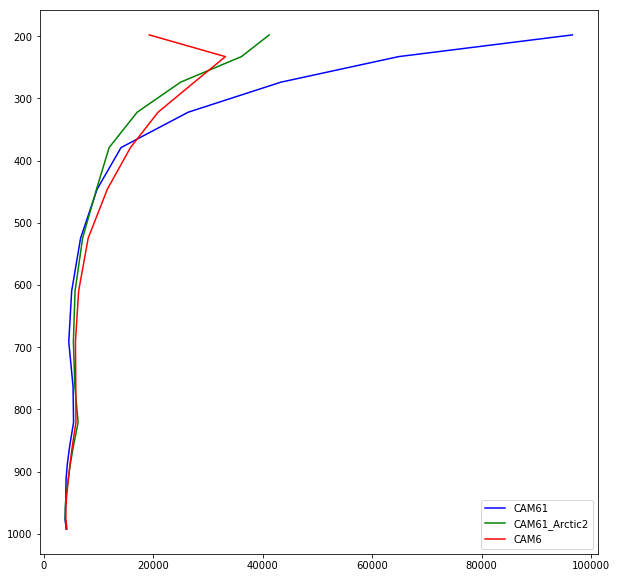

In [68]:
test_plot = plt.figure(figsize=[10,10])
colors = ['blue','green','red','orange','purple','yellow', 'pink']

test_plot.gca().invert_yaxis()
for case, _col, nm in zip(cases, colors, names):
    _da = add_weights(case)
    weight = _da['cell_weight']
    working_da = _da['AWNI']/_da['FREQI'].sel(lat=slice(-90,-67)) # select variable and lat range
    working_da = working_da.mean(dim='time') # select time or average by it
#            weight = working_da['cell_weight']
    avg_var = masked_average(working_da, dim=['lat','lon'],weights=weight) # finally actually compute on the bounded variable of interest
    plt.plot(avg_var, avg_var['lev'], label=nm, color=_col)
    
plt.legend()

In [22]:
#        return _da
xaxis_label = '%s (%s)' % (var_str, _da[var_str].units)

plt.legend(loc='upper right')
test_plot.suptitle(_da[var_str].long_name, fontsize=24)
plt.xlabel(xaxis_label); plt.ylabel('Hybrid Sigma pressure (hPa)');

<xarray.Dataset>
Dimensions:           (isotherms_mpc: 9, lat: 96, lev: 32, lon: 144, time: 1)
Coordinates:
  * isotherms_mpc     (isotherms_mpc) float64 233.1 238.1 243.1 ... 268.1 273.1
  * lat               (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * time              (time) datetime64[ns] 2000-02-01
  * lev               (lev) float64 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * lon               (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    cell_weight       (lat, lon) float64 ...
    gw                (lat) float64 ...
    TS                (time, lat, lon) float32 ...
    CT_SLF            (time, isotherms_mpc, lat, lon) float32 ...
    CT_SLF_ISOTM_AVG  (isotherms_mpc, lat, lon) float32 ...
    CT_SLFXCLD_ISOTM  (time, isotherms_mpc, lat, lon) float32 ...
    CT_CLD_ISOTM      (time, isotherms_mpc, lat, lon) float32 ...
    SLFXCLD_ISOTM     (time, isotherms_mpc, lat, lon) float32 ...
    CLD_ISOTM         (time, isotherms_mpc, lat, lon) float32 ...
    AREI              (time, lev, lat, lon) float32 ...
    FREQI             (time, lev, lat, lon) float32 ...
    NUMICE            (time, lev, lat, lon) float32 ...
    NUMICE10s         (time, lev, lat, lon) float32 ...
    DSTFREZIMM        (time, lev, lat, lon) float32 ...
    DSTFREZCNT        (time, lev, lat, lon) float32 ...
    DSTFREZDEP        (time, lev, lat, lon) float32 ...
    AWNI              (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              20200227_140941_singleparam_cam61arctic_wbf_1_inp_1
    logname:           jonahks
    host:              
    initial_file:      /cluster/shared/noresm/inputdata/atm/cam/inic/fv/cami-...
    topography_file:   /cluster/shared/noresm/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [3]:
os.listdir(mods_dir)

['20200207_145043_singleparam_icenucmod_wbf_1_inp_1',
 '20200218_143308_singleparam_nimaxmpconly_wbf_1_inp_10020200218_143308_singleparam_nimaxmpconly_wbf_1_inp_100cloudtop_slf_comparison.csv',
 '20200218_143308_singleparam_nimaxmpconly_wbf_1_inp_120200218_143308_singleparam_nimaxmpconly_wbf_1_inp_1cloudtop_slf_comparison.csv',
 '20200131_120822_singleparam_nimaxmod_wbf_1_inp_1',
 '20200109_nfclimo_f19tn14',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_120200207_145043_singleparam_icenucmod_wbf_1_inp_1cloudtop_slf_comparison.csv',
 '20200218_143308_singleparam_nimaxmpconly_wbf_1_inp_1',
 '20200218_143308_singleparam_nimaxmpconly_wbf_1_inp_100',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_1020200207_145043_singleparam_icenucmod_wbf_1_inp_10cloudtop_slf_comparison.csv',
 '20200227_140941_singleparam_cam61arctic_wbf_1_inp_1',
 '20200207_145043_singleparam_icenucmod_wbf_1_inp_10',
 '20200128_162401_singleparam_altINPm1_wbf_1_inp_100',
 '20200218_112948_singleparam_nimaxmpconly_w